In [12]:
import os
import pickle

import hmmlearn.hmm as hmm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
class HMMTraining:
    def __init__(self):
        self.class_names = [
            'A', 'Ba', 'Bài', 'Bảy', 'Bốn', 'Chậm', 'Chạy', 'Chín', 'Chủ', 'Có',
            'Cuối', 'Đầu', 'Đọc', 'Dừng', 'Đúng', 'E', 'Giảm', 'Giờ', 'Giúp', 'Hai',
            'Hủy', 'I', 'Kế', 'Không', 'Lại', 'Lặp', 'Lui', 'Lưu', 'Một', 'Mục',
            'Năm', 'Ngày', 'Ngừng', 'Nhanh', 'Nhỏ', 'O', 'Sai', 'Sáu', 'Tải', 'Tám',
            'Tăng', 'Thổ địa', 'Tiếp', 'To', 'Tới', 'Trước', 'Tuổi', 'U', 'Vào', 'Về',
            'Xóa', 'Xong'
            ]
        # số lượng trạng thái
        self.states = [
            3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
            3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
            3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
            3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
            3, 4, 3, 3, 3, 3, 3, 3, 3, 3,
            3, 3
            ]
        # Số lượng hỗn hợp (mix) cho từng lớp
        self.n_mix_values = {
            'A': 3, 'Ba': 3, 'Bài': 3, 'Bảy': 3, 'Bốn': 3, 'Chậm': 3, 'Chạy': 3, 'Chín': 3, 'Chủ': 3, 'Có': 3,
            'Cuối': 3, 'Đầu': 3, 'Đọc': 3, 'Dừng': 3, 'Đúng': 3, 'E': 3, 'Giảm': 3, 'Giờ': 3, 'Giúp': 3, 'Hai': 3,
            'Hủy': 3, 'I': 3, 'Kế': 3, 'Không': 3, 'Lại': 3, 'Lặp': 3, 'Lui': 3, 'Lưu': 3, 'Một': 3, 'Mục': 3,
            'Năm': 3, 'Ngày': 3, 'Ngừng': 3, 'Nhanh': 3, 'Nhỏ': 3, 'O': 3, 'Sai': 3, 'Sáu': 3, 'Tải': 3, 'Tám': 3,
            'Tăng': 3, 'Thổ địa': 3, 'Tiếp': 3, 'To': 3, 'Tới': 3, 'Trước': 3, 'Tuổi': 3, 'U': 3, 'Vào': 3, 'Về': 3,
            'Xóa': 3, 'Xong': 3
            }  
        self.dataset_path = 'datasets'

        self.X = {'train': {}, 'test': {}}
        self.y = {'train': {}, 'test': {}}

        self.model = {}
        self.model_path = 'models_train'

    def train(self):
        length = 0
        for cn in self.class_names:
            length += len(os.listdir(f"{self.dataset_path}/{cn}"))
        print('Total samples:', length)

        all_data = {}
        all_labels = {}
        for cname in self.class_names:
            file_paths = [os.path.join(self.dataset_path, cname, i) for i in os.listdir(
                os.path.join(self.dataset_path, cname)) if i.endswith('.wav')]
            data = [preprocessing.get_mfcc(file_path) for file_path in file_paths]
            all_data[cname] = data
            all_labels[cname] = [self.class_names.index(cname) for _ in range(len(file_paths))]

        for cname in self.class_names:
            x_train, x_test, y_train, y_test = train_test_split(
                all_data[cname], all_labels[cname],
                # test_size=6/14,
                test_size=0.25,
                random_state=42
            )

            self.X['train'][cname] = x_train
            self.X['test'][cname] = x_test
            self.y['test'][cname] = y_test

        total_train = 0
        total_test = 0
        for cname in self.class_names:
            train_count = len(self.X['train'][cname])
            test_count = len(self.X['test'][cname])
            print(cname, 'train:', train_count, '| test:', test_count)
            total_train += train_count
            total_test += test_count
        print('train samples:', total_train)
        print('test samples', total_test)
        
        self.log_likelihoods = {}
        for idx, cname in enumerate(self.class_names):
            start_prob = np.full(self.states[idx], 0.0)
            start_prob[0] = 1.0
            trans_matrix = np.full((self.states[idx], self.states[idx]), 0.0)
            # xac xuất chuyển trang thai
            p = 0.5
            np.fill_diagonal(trans_matrix, p)
            np.fill_diagonal(trans_matrix[0:, 1:], 1 - p)
            trans_matrix[-1, -1] = 1.0

            # trans matrix
            print(cname)
            print(trans_matrix)

            # Sử dung n_mix tu dictionary n_mix_values
            n_mix = self.n_mix_values.get(cname, 3)  # Mac Dinh la 3 neu khong co gia tri cho lop Do

            self.model[cname] = hmm.GMMHMM(
                n_components=self.states[idx],
                n_mix=n_mix,  # Sử dung so luợng hỗn hợp cho lop hiện tai
                verbose=True,
                # so lan lap
                n_iter=300,
                startprob_prior=start_prob,
                transmat_prior=trans_matrix,
                params='stmc',
                init_params='mc',
                random_state=42
            )
            self.model[cname].fit(X=np.vstack(self.X['train'][cname]),
                                  lengths=[x.shape[0] for x in self.X['train'][cname]])
            # Luu log-likelihood vao dictionary
            self.log_likelihoods[cname] = self.model[cname].monitor_.history

    def save_model(self):
        for cname in self.class_names:
            name = f'{self.model_path}/model_{cname}.pkl'
            with open(name, 'wb') as file:
                pickle.dump(self.model[cname], file)

    def evaluation(self):
        print('====== Evaluation ======')
        y_true = []
        y_pred = []
        class_accuracies = []

        # Duyệt qua tung class name
        for cname in self.class_names:
            y_true_class = []
            y_pred_class = []

            # Duyệt qua tung mẫu trong tap test
            for mfcc, target in zip(self.X['test'][cname], self.y['test'][cname]):
                # Tinh Diểm cho tung class
                scores = [self.model[c].score(mfcc) for c in self.class_names]
                pred = np.argmax(scores)
                y_pred_class.append(pred)
                y_true_class.append(target)
                y_true.append(target)
                y_pred.append(pred)

            # Tinh Do chinh xac cho tung lop
            class_accuracy = accuracy_score(y_true_class, y_pred_class)
            class_accuracies.append(class_accuracy)
            print(f'{cname}: {class_accuracy:.2f}')

        # Tinh Do chinh xac trung bình
        average_accuracy = sum(class_accuracies) / len(class_accuracies)
        print('======')
        print(f'Trung bình chung: {average_accuracy:.2f}')
        
        # Tinh ma tran nham lẫn
        cm = confusion_matrix(y_true, y_pred)

        # Vẽ ma tran nham lẫn
        plt.figure(figsize=(16, 16))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    
    def plot_log_likelihood(self):
        for cname in self.class_names:
            plt.figure(figsize=(8, 5))
            plt.plot(self.log_likelihoods[cname], label=f'Log-Likelihood - {cname}', color='blue')
            plt.xlabel('Iterations')
            plt.ylabel('Log-Likelihood')
            plt.title(f'Log-Likelihood Progression for {cname}')
            plt.legend()
            plt.grid()
            plt.show()

Total samples: 1040
A train: 15 | test: 5
Ba train: 15 | test: 5
Bài train: 15 | test: 5
Bảy train: 15 | test: 5
Bốn train: 15 | test: 5
Chậm train: 15 | test: 5
Chạy train: 15 | test: 5
Chín train: 15 | test: 5
Chủ train: 15 | test: 5
Có train: 15 | test: 5
Cuối train: 15 | test: 5
Đầu train: 15 | test: 5
Đọc train: 15 | test: 5
Dừng train: 15 | test: 5
Đúng train: 15 | test: 5
E train: 15 | test: 5
Giảm train: 15 | test: 5
Giờ train: 15 | test: 5
Giúp train: 15 | test: 5
Hai train: 15 | test: 5
Hủy train: 15 | test: 5
I train: 15 | test: 5
Kế train: 15 | test: 5
Không train: 15 | test: 5
Lại train: 15 | test: 5
Lặp train: 15 | test: 5
Lui train: 15 | test: 5
Lưu train: 15 | test: 5
Một train: 15 | test: 5
Mục train: 15 | test: 5
Năm train: 15 | test: 5
Ngày train: 15 | test: 5
Ngừng train: 15 | test: 5
Nhanh train: 15 | test: 5
Nhỏ train: 15 | test: 5
O train: 15 | test: 5
Sai train: 15 | test: 5
Sáu train: 15 | test: 5
Tải train: 15 | test: 5
Tám train: 15 | test: 5
Tăng train: 15 |

         1 -249564.88839772             +nan
         2 -220130.04106585  +29434.84733186
         3 -214408.64791952   +5721.39314633
         4 -212684.04741646   +1724.60050307
         5 -211868.06643332    +815.98098314
         6 -211467.57235525    +400.49407807
         7 -211214.46317239    +253.10918286
         8 -210997.02983588    +217.43333652
         9 -210796.82953800    +200.20029788
        10 -210553.77481531    +243.05472269
        11 -210343.96339697    +209.81141834
        12 -210229.24225954    +114.72113742
        13 -210182.47427922     +46.76798032
        14 -210161.34745457     +21.12682466
        15 -210146.87605689     +14.47139768
        16 -210136.03225504     +10.84380185
        17 -210123.35018379     +12.68207125
        18 -210108.27813316     +15.07205063
        19 -210101.23466535      +7.04346781
        20 -210099.55318419      +1.68148116
        21 -210098.61800570      +0.93517849
        22 -210097.90847700      +0.70952871
        23

Ba
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -253469.68248329             +nan
         2 -219360.39422791  +34109.28825538
         3 -216716.85144943   +2643.54277849
         4 -215918.27996672    +798.57148271
         5 -215548.56178224    +369.71818448
         6 -215350.33047026    +198.23131198
         7 -215189.62409215    +160.70637811
         8 -215105.30783901     +84.31625314
         9 -215054.25032045     +51.05751856
        10 -215019.52949650     +34.72082395
        11 -214997.23109940     +22.29839709
        12 -214976.47569059     +20.75540881
        13 -214957.78427710     +18.69141349
        14 -214937.21911323     +20.56516387
        15 -214916.63270616     +20.58640707
        16 -214891.96089085     +24.67181530
        17 -214857.99317857     +33.96771229
        18 -214815.94239157     +42.05078700
        19 -214784.81709534     +31.12529623
        20 -214763.63152507     +21.18557027
        21 -214748.78736651     +14.84415856
        22 -214737.32963265     +11.45773386
        23

Bài
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -245029.42253503             +nan
         2 -213808.16195866  +31221.26057637
         3 -209833.28544331   +3974.87651536
         4 -208971.87619509    +861.40924822
         5 -208705.05246494    +266.82373015
         6 -208518.60727640    +186.44518854
         7 -208418.81092267     +99.79635373
         8 -208381.64100097     +37.16992170
         9 -208353.67270879     +27.96829219
        10 -208321.37082277     +32.30188601
        11 -208285.31949480     +36.05132797
        12 -208251.17754638     +34.14194842
        13 -208217.29265092     +33.88489546
        14 -208186.25258259     +31.04006833
        15 -208157.73797591     +28.51460668
        16 -208133.51480637     +24.22316954
        17 -208114.58699276     +18.92781361
        18 -208101.12795967     +13.45903309
        19 -208093.86318813      +7.26477154
        20 -208088.91747257      +4.94571556
        21 -208084.78753925      +4.12993332
        22 -208080.70683399      +4.08070526
        23

Bảy
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         2 -212203.23891582  +35832.16296205
         3 -209728.92707907   +2474.31183675
         4 -209182.59551935    +546.33155972
         5 -208982.60035099    +199.99516836
         6 -208893.53246212     +89.06788887
         7 -208849.71230936     +43.82015276
         8 -208817.70767346     +32.00463590
         9 -208776.77521697     +40.93245649
        10 -208737.03152568     +39.74369129
        11 -208703.49110958     +33.54041610
        12 -208673.49995957     +29.99115001
        13 -208640.22098837     +33.27897119
        14 -208619.85170420     +20.36928418
        15 -208605.38083700     +14.47086720
        16 -208593.17632179     +12.20451521
        17 -208582.94159369     +10.23472809
        18 -208574.85473820      +8.08685550
        19 -208568.14588603      +6.70885217
        20 -208562.57569969      +5.57018633
        21 -208558.41026978      +4.16542992
        22 -208555.35618734      +3.05408243
        23 -208552.95508782      +2.40109953
        24

Bốn
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -238366.18311891             +nan
         2 -216766.36895794  +21599.81416097
         3 -210006.45864832   +6759.91030962
         4 -208122.26330482   +1884.19534351
         5 -207566.76437005    +555.49893476
         6 -207344.24086870    +222.52350135
         7 -207192.47274928    +151.76811941
         8 -207075.56727159    +116.90547769
         9 -207029.99735220     +45.56991939
        10 -206991.10373206     +38.89362013
        11 -206914.94095610     +76.16277596
        12 -206800.05563060    +114.88532551
        13 -206723.91761309     +76.13801751
        14 -206665.44266179     +58.47495130
        15 -206604.73223206     +60.71042973
        16 -206556.51221447     +48.22001759
        17 -206538.33133463     +18.18087984
        18 -206533.31788544      +5.01344920
        19 -206529.87535646      +3.44252898
        20 -206526.66577437      +3.20958210
        21 -206523.36724286      +3.29853150
        22 -206519.80347373      +3.56376913
        23

Chậm
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -241182.18598084             +nan
         2 -215179.68832824  +26002.49765261
         3 -207792.13507334   +7387.55325490
         4 -206781.45559741   +1010.67947593
         5 -206501.96914584    +279.48645156
         6 -206333.45355125    +168.51559459
         7 -206248.98203099     +84.47152026
         8 -206193.71541765     +55.26661335
         9 -206137.55907744     +56.15634020
        10 -206087.18822687     +50.37085057
        11 -205959.68855076    +127.49967611
        12 -205901.89387045     +57.79468031
        13 -205890.44164048     +11.45222997
        14 -205879.20937569     +11.23226479
        15 -205870.02743994      +9.18193574
        16 -205860.35789461      +9.66954534
        17 -205849.17553838     +11.18235623
        18 -205833.23600272     +15.93953566
        19 -205809.82975479     +23.40624793
        20 -205781.78658106     +28.04317374
        21 -205747.54756239     +34.23901866
        22 -205708.86569176     +38.68187063
        23

Chạy
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         2 -206430.27536275  +36107.14515528
         3 -203200.66328703   +3229.61207572
         4 -202345.63999391    +855.02329313
         5 -202168.77996813    +176.86002578
         6 -202101.73620675     +67.04376138
         7 -202066.73788783     +34.99831892
         8 -202048.82777518     +17.91011265
         9 -202031.91802061     +16.90975457
        10 -202011.41106974     +20.50695087
        11 -201987.94158565     +23.46948409
        12 -201962.46128885     +25.48029680
        13 -201928.12079939     +34.34048946
        14 -201878.25252270     +49.86827669
        15 -201820.52658483     +57.72593787
        16 -201776.22334193     +44.30324290
        17 -201745.12526132     +31.09808061
        18 -201722.92964874     +22.19561258
        19 -201705.11019801     +17.81945074
        20 -201687.41633251     +17.69386550
        21 -201670.62727042     +16.78906209
        22 -201653.13844657     +17.48882385
        23 -201617.29506055     +35.84338603
        24

Chín
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -225824.06603898             +nan
         2 -204506.88636809  +21317.17967089
         3 -201541.36162194   +2965.52474615
         4 -200895.16868632    +646.19293562
         5 -200585.36091552    +309.80777080
         6 -200336.12770936    +249.23320616
         7 -200182.22250762    +153.90520173
         8 -200087.85417044     +94.36833718
         9 -200003.65454297     +84.19962747
        10 -199947.13015990     +56.52438307
        11 -199923.46987868     +23.66028122
        12 -199908.72207292     +14.74780577
        13 -199898.71748374     +10.00458918
        14 -199890.44143044      +8.27605330
        15 -199883.34001256      +7.10141787
        16 -199876.05919879      +7.28081377
        17 -199868.38335478      +7.67584401
        18 -199859.52822741      +8.85512738
        19 -199850.23256937      +9.29565804
        20 -199844.24572362      +5.98684575
        21 -199838.83429745      +5.41142617
        22 -199833.53743084      +5.29686660
        23

Chủ
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -258889.80523907             +nan
         2 -221970.41913052  +36919.38610855
         3 -218818.18122325   +3152.23790727
         4 -217707.62414859   +1110.55707466
         5 -217301.75736514    +405.86678345
         6 -217099.28598206    +202.47138309
         7 -216976.38593997    +122.90004209
         8 -216855.50673576    +120.87920421
         9 -216796.46024947     +59.04648629
        10 -216769.66827695     +26.79197252
        11 -216758.89059241     +10.77768454
        12 -216749.21662267      +9.67396974
        13 -216743.93574281      +5.28087985
        14 -216742.66465324      +1.27108957
        15 -216742.11283597      +0.55181727
        16 -216741.73253566      +0.38030031
        17 -216741.18004771      +0.55248794
        18 -216740.09342546      +1.08662225
        19 -216738.87046078      +1.22296468
        20 -216737.82403540      +1.04642538
        21 -216737.04875997      +0.77527543
        22 -216736.75890657      +0.28985340
        23

Có
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -250242.30115431             +nan
         2 -219565.45203942  +30676.84911489
         3 -213229.56839995   +6335.88363947
         4 -212469.35896989    +760.20943006
         5 -212312.89398361    +156.46498628
         6 -212241.27954003     +71.61444358
         7 -212187.45267607     +53.82686396
         8 -212105.87832940     +81.57434667
         9 -212017.70542263     +88.17290678
        10 -211927.12035216     +90.58507046
        11 -211813.93755360    +113.18279857
        12 -211700.71185868    +113.22569492
        13 -211591.96898659    +108.74287209
        14 -211462.04946408    +129.91952251
        15 -211383.14892420     +78.90053988
        16 -211333.43681053     +49.71211368
        17 -211303.01669681     +30.42011371
        18 -211284.83355185     +18.18314496
        19 -211273.73515787     +11.09839398
        20 -211266.68099911      +7.05415876
        21 -211261.94384572      +4.73715339
        22 -211258.53129106      +3.41255466
        23

Cuối
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -236055.06065313             +nan
         2 -210846.88022327  +25208.18042985
         3 -204869.15057181   +5977.72965147
         4 -203448.36605054   +1420.78452126
         5 -202746.98347987    +701.38257067
         6 -202376.96563533    +370.01784454
         7 -202227.98259627    +148.98303907
         8 -202175.79900034     +52.18359593
         9 -202146.24051337     +29.55848697
        10 -202129.07952988     +17.16098349
        11 -202116.02087905     +13.05865083
        12 -202091.36968275     +24.65119630
        13 -202062.65677127     +28.71291148
        14 -202045.13451653     +17.52225474
        15 -202035.03418662     +10.10032991
        16 -202025.65734826      +9.37683836
        17 -202019.90500127      +5.75234698
        18 -202017.46530173      +2.43969954
        19 -202015.99159044      +1.47371129
        20 -202014.46515049      +1.52643995
        21 -202012.35384162      +2.11130887
        22 -202010.24172587      +2.11211575
        23

Đầu
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -238167.95304503             +nan
         2 -203707.42348283  +34460.52956220
         3 -201935.03874462   +1772.38473821
         4 -201386.18452773    +548.85421689
         5 -201095.87489226    +290.30963546
         6 -200897.44962698    +198.42526528
         7 -200744.72543300    +152.72419398
         8 -200658.97053502     +85.75489798
         9 -200626.05747151     +32.91306351
        10 -200612.99889026     +13.05858125
        11 -200605.52219234      +7.47669792
        12 -200599.16754031      +6.35465204
        13 -200592.78700308      +6.38053723
        14 -200586.67999462      +6.10700846
        15 -200577.41831614      +9.26167848
        16 -200570.57438724      +6.84392890
        17 -200568.65553802      +1.91884922
        18 -200567.67412932      +0.98140870
        19 -200567.05010975      +0.62401957
        20 -200566.63597939      +0.41413037
        21 -200566.34491264      +0.29106674
        22 -200566.12788392      +0.21702872
        23

Đọc
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -232671.59156991             +nan
         2 -198237.65619451  +34433.93537540
         3 -196241.19204317   +1996.46415134
         4 -195583.79442370    +657.39761947
         5 -195267.90736842    +315.88705527
         6 -195101.31293203    +166.59443640
         7 -195006.58229258     +94.73063945
         8 -194950.48898444     +56.09330813
         9 -194915.21948688     +35.26949757
        10 -194899.68815212     +15.53133475
        11 -194891.96268841      +7.72546371
        12 -194883.52501500      +8.43767341
        13 -194873.69533204      +9.82968296
        14 -194868.54643470      +5.14889734
        15 -194865.45617103      +3.09026366
        16 -194863.95878438      +1.49738665
        17 -194862.75373488      +1.20504950
        18 -194861.72131975      +1.03241513
        19 -194860.86402130      +0.85729844
        20 -194860.21266603      +0.65135527
        21 -194859.77291933      +0.43974670
        22 -194859.49153122      +0.28138812
        23

Dừng
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -235126.64214600             +nan
         2 -200313.21519530  +34813.42695070
         3 -198228.74829106   +2084.46690424
         4 -197573.03394775    +655.71434331
         5 -197296.22854999    +276.80539776
         6 -197165.94639873    +130.28215126
         7 -197118.32577449     +47.62062424
         8 -197095.53439427     +22.79138022
         9 -197081.18441688     +14.34997739
        10 -197073.74017368      +7.44424320
        11 -197066.84578237      +6.89439131
        12 -197063.40171203      +3.44407034
        13 -197060.84637705      +2.55533498
        14 -197058.04059921      +2.80577784
        15 -197054.75239542      +3.28820379
        16 -197050.87142763      +3.88096779
        17 -197046.24879157      +4.62263607
        18 -197043.66630315      +2.58248842
        19 -197041.61753296      +2.04877019
        20 -197038.80806325      +2.80946971
        21 -197035.89149767      +2.91656558
        22 -197028.14914063      +7.74235704
        23

Đúng
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -233522.70863425             +nan
         2 -199014.76740192  +34507.94123233
         3 -196880.84937887   +2133.91802305
         4 -196212.00969011    +668.83968875
         5 -195991.43366432    +220.57602579
         6 -195874.23565037    +117.19801395
         7 -195793.78971419     +80.44593618
         8 -195728.16646719     +65.62324700
         9 -195666.14538990     +62.02107728
        10 -195636.98508132     +29.16030858
        11 -195615.20024408     +21.78483724
        12 -195597.24157020     +17.95867388
        13 -195581.73795376     +15.50361644
        14 -195568.73136666     +13.00658710
        15 -195558.24195209     +10.48941457
        16 -195550.99049531      +7.25145678
        17 -195547.08439710      +3.90609821
        18 -195544.68184794      +2.40254916
        19 -195542.02638624      +2.65546170
        20 -195538.53616001      +3.49022623
        21 -195537.43014138      +1.10601863
        22 -195536.82515004      +0.60499134
        23

E
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -241355.54930768             +nan
         2 -213036.43358524  +28319.11572244
         3 -206962.04632487   +6074.38726037
         4 -205584.07706928   +1377.96925559
         5 -205058.67767240    +525.39939688
         6 -204800.02424516    +258.65342724
         7 -204650.47099559    +149.55324958
         8 -204511.83804270    +138.63295289
         9 -204348.24733414    +163.59070856
        10 -204230.48044469    +117.76688944
        11 -204192.37587589     +38.10456880
        12 -204147.56811601     +44.80775988
        13 -204103.25799219     +44.31012382
        14 -204088.67070459     +14.58728760
        15 -204079.22390311      +9.44680148
        16 -204073.23514750      +5.98875561
        17 -204068.09934765      +5.13579985
        18 -204062.11914109      +5.98020656
        19 -204054.97667197      +7.14246912
        20 -204047.47451735      +7.50215462
        21 -204042.86474687      +4.60977048
        22 -204040.41534667      +2.44940020
        23

Giảm
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -247742.94615447             +nan
         2 -213959.82517600  +33783.12097847
         3 -210986.43768877   +2973.38748723
         4 -210509.14094602    +477.29674275
         5 -210396.18985785    +112.95108817
         6 -210351.95374806     +44.23610979
         7 -210332.78996277     +19.16378529
         8 -210323.87933669      +8.91062608
         9 -210317.90563150      +5.97370519
        10 -210312.23484183      +5.67078966
        11 -210309.28878261      +2.94605922
        12 -210306.38448688      +2.90429573
        13 -210302.41572115      +3.96876573
        14 -210296.18313888      +6.23258227
        15 -210289.73836963      +6.44476926
        16 -210282.55917505      +7.17919457
        17 -210274.38122710      +8.17794796
        18 -210267.36936222      +7.01186488
        19 -210260.60094120      +6.76842102
        20 -210253.90755812      +6.69338308
        21 -210247.80486414      +6.10269398
        22 -210242.80783874      +4.99702540
        23

Giờ
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -225896.73809779             +nan
         2 -204997.44977192  +20899.28832587
         3 -202408.95686324   +2588.49290868
         4 -201703.19084122    +705.76602202
         5 -201371.95933446    +331.23150676
         6 -201180.38297920    +191.57635525
         7 -201044.71607258    +135.66690662
         8 -200973.65772018     +71.05835240
         9 -200939.53138719     +34.12633300
        10 -200909.30323765     +30.22814954
        11 -200835.25226232     +74.05097533
        12 -200787.80746417     +47.44479815
        13 -200760.03058458     +27.77687958
        14 -200731.57987415     +28.45071044
        15 -200710.58624175     +20.99363239
        16 -200702.80474035      +7.78150140
        17 -200696.94006421      +5.86467614
        18 -200692.09624475      +4.84381945
        19 -200688.86355204      +3.23269272
        20 -200686.10808612      +2.75546592
        21 -200683.44862824      +2.65945788
        22 -200680.71332430      +2.73530393
        23

Giúp
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -220290.37962381             +nan
         2 -187661.41263467  +32628.96698913
         3 -185841.27538082   +1820.13725385
         4 -185408.08550876    +433.18987206
         5 -185199.28369431    +208.80181445
         6 -185094.06773949    +105.21595483
         7 -185038.50149063     +55.56624885
         8 -185010.32646314     +28.17502750
         9 -184993.21127713     +17.11518600
        10 -184980.96205405     +12.24922309
        11 -184969.22924723     +11.73280682
        12 -184959.54886382      +9.68038341
        13 -184952.74798423      +6.80087959
        14 -184947.13620707      +5.61177715
        15 -184942.23518896      +4.90101811
        16 -184937.82796068      +4.40722828
        17 -184933.76358422      +4.06437647
        18 -184929.96571442      +3.79786980
        19 -184926.46470081      +3.50101361
        20 -184923.33579288      +3.12890793
        21 -184920.64918011      +2.68661277
        22 -184918.50127474      +2.14790537
        23

Hai
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -243406.23477060             +nan
         2 -213200.21863649  +30206.01613411
         3 -209947.90160540   +3252.31703109
         4 -209188.06320365    +759.83840174
         5 -208908.05926154    +280.00394211
         6 -208716.66042366    +191.39883789
         7 -208592.29592523    +124.36449843
         8 -208505.26765040     +87.02827483
         9 -208453.59017408     +51.67747632
        10 -208420.29687108     +33.29330300
        11 -208394.34384151     +25.95302957
        12 -208368.07896262     +26.26487889
        13 -208350.15488039     +17.92408223
        14 -208330.07608351     +20.07879688
        15 -208290.14569835     +39.93038516
        16 -208245.53994763     +44.60575073
        17 -208193.55939602     +51.98055161
        18 -208156.20598519     +37.35341082
        19 -208133.84369141     +22.36229378
        20 -208122.67032021     +11.17337120
        21 -208111.75863767     +10.91168254
        22 -208099.17242521     +12.58621246
        23

Hủy
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -242768.34172868             +nan
         2 -209898.85446111  +32869.48726757
         3 -207899.30584531   +1999.54861579
         4 -207467.60283702    +431.70300829
         5 -207302.12089842    +165.48193861
         6 -207227.28617946     +74.83471895
         7 -207176.95592787     +50.33025159
         8 -207125.39976734     +51.55616053
         9 -207081.51179204     +43.88797530
        10 -207055.72058402     +25.79120802
        11 -207033.18161177     +22.53897225
        12 -207006.06159120     +27.12002057
        13 -206996.06448103      +9.99711016
        14 -206990.00554572      +6.05893531
        15 -206963.06536174     +26.94018398
        16 -206935.47860325     +27.58675849
        17 -206929.61559693      +5.86300632
        18 -206925.55401005      +4.06158688
        19 -206921.55211101      +4.00189904
        20 -206916.83261748      +4.71949353
        21 -206909.81451463      +7.01810285
        22 -206901.87413640      +7.94037823
        23

I
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -235106.00491352             +nan
         2 -202913.98414702  +32192.02076649
         3 -198942.82995782   +3971.15418920
         4 -198367.90855620    +574.92140162
         5 -198158.20015193    +209.70840427
         6 -197894.36672272    +263.83342921
         7 -197535.15867008    +359.20805265
         8 -197272.05457337    +263.10409671
         9 -196981.00696183    +291.04761154
        10 -196658.39237671    +322.61458512
        11 -196329.80057875    +328.59179796
        12 -196048.78813173    +281.01244702
        13 -195899.03899604    +149.74913568
        14 -195806.97423654     +92.06475950
        15 -195755.62206611     +51.35217042
        16 -195712.28073620     +43.34132991
        17 -195676.14053589     +36.14020031
        18 -195652.64182548     +23.49871042
        19 -195640.94130736     +11.70051812
        20 -195635.75544019      +5.18586717
        21 -195632.72047137      +3.03496882
        22 -195630.14910608      +2.57136530
        23

Kế
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -228898.71586384             +nan
         2 -206395.76270484  +22502.95315900
         3 -203488.52238743   +2907.24031741
         4 -202624.16273018    +864.35965725
         5 -202345.40636790    +278.75636228
         6 -202184.16155666    +161.24481124
         7 -202029.39613204    +154.76542462
         8 -201933.81715701     +95.57897503
         9 -201900.10222849     +33.71492852
        10 -201891.27199333      +8.83023516
        11 -201888.36363180      +2.90836153
        12 -201887.01423918      +1.34939262
        13 -201885.84264977      +1.17158941
        14 -201884.45843648      +1.38421329
        15 -201882.99479170      +1.46364478
        16 -201881.46066159      +1.53413010
        17 -201880.02410524      +1.43655635
        18 -201877.87158831      +2.15251693
        19 -201874.86951359      +3.00207473
        20 -201873.37540546      +1.49410813
        21 -201872.95162520      +0.42378026
        22 -201872.76450311      +0.18712208
        23

Không
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -240816.34329737             +nan
         2 -209177.42745401  +31638.91584335
         3 -206920.41766713   +2257.00978688
         4 -206470.55023848    +449.86742865
         5 -206298.04115619    +172.50908230
         6 -206240.80101403     +57.24014215
         7 -206213.13037886     +27.67063517
         8 -206197.23918403     +15.89119484
         9 -206174.50069740     +22.73848663
        10 -206154.57382053     +19.92687687
        11 -206148.45407335      +6.11974718
        12 -206140.53867264      +7.91540071
        13 -206129.72110676     +10.81756588
        14 -206120.75917978      +8.96192698
        15 -206111.57319245      +9.18598733
        16 -206102.04971283      +9.52347962
        17 -206091.94645611     +10.10325672
        18 -206074.96465777     +16.98179835
        19 -206055.76043370     +19.20422407
        20 -206037.43315279     +18.32728091
        21 -206020.16779858     +17.26535421
        22 -205986.36716839     +33.80063019
        23

Lại
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -250556.65343869             +nan
         2 -217212.65382996  +33343.99960873
         3 -213800.04824782   +3412.60558214
         4 -212963.86649867    +836.18174915
         5 -212663.51923834    +300.34726033
         6 -212549.10415839    +114.41507995
         7 -212525.87384681     +23.23031158
         8 -212461.48529894     +64.38854787
         9 -212422.64518578     +38.84011316
        10 -212380.21707075     +42.42811503
        11 -212336.03130995     +44.18576081
        12 -212292.76158512     +43.26972482
        13 -212245.54440817     +47.21717696
        14 -212186.08750960     +59.45689856
        15 -212105.88891695     +80.19859265
        16 -212043.05600325     +62.83291370
        17 -212004.08376039     +38.97224286
        18 -211973.15951532     +30.92424507
        19 -211949.21772261     +23.94179271
        20 -211936.66337297     +12.55434964
        21 -211928.25210412      +8.41126885
        22 -211922.39309110      +5.85901302
        23

Lặp
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -235320.85581056             +nan
         2 -203369.33175731  +31951.52405324
         3 -200757.21899858   +2612.11275873
         4 -199984.57733525    +772.64166333
         5 -199792.88782221    +191.68951304
         6 -199736.95953642     +55.92828580
         7 -199696.18629040     +40.77324602
         8 -199635.42597768     +60.76031272
         9 -199573.58153780     +61.84443988
        10 -199509.14564809     +64.43588971
        11 -199421.83464549     +87.31100260
        12 -199325.19161338     +96.64303211
        13 -199230.07203495     +95.11957843
        14 -199133.20504952     +96.86698543
        15 -199031.84048217    +101.36456735
        16 -198955.98287695     +75.85760522
        17 -198898.03680827     +57.94606868
        18 -198843.23895842     +54.79784984
        19 -198811.54764845     +31.69130997
        20 -198800.26916864     +11.27847981
        21 -198796.99101375      +3.27815489
        22 -198795.23683908      +1.75417467
        23

Lui
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -233977.54778998             +nan
         2 -209384.11191731  +24593.43587267
         3 -207041.14704338   +2342.96487393
         4 -206367.90125999    +673.24578339
         5 -206122.94747100    +244.95378899
         6 -205970.82649480    +152.12097620
         7 -205863.92281667    +106.90367812
         8 -205789.46562297     +74.45719370
         9 -205728.32776217     +61.13786080
        10 -205660.88240028     +67.44536189
        11 -205614.95050731     +45.93189297
        12 -205591.49043618     +23.46007113
        13 -205582.65763738      +8.83279880
        14 -205579.60618524      +3.05145214
        15 -205577.06132746      +2.54485778
        16 -205573.56084141      +3.50048605
        17 -205570.62062011      +2.94022129
        18 -205569.35850329      +1.26211682
        19 -205568.54492047      +0.81358282
        20 -205567.91924932      +0.62567115
        21 -205567.44174884      +0.47750048
        22 -205567.10268032      +0.33906851
        23

Lưu
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -230764.03589705             +nan
         2 -209058.86113194  +21705.17476511
         3 -203293.56208104   +5765.29905090
         4 -201284.60242936   +2008.95965168
         5 -200617.85534341    +666.74708596
         6 -200234.00626958    +383.84907382
         7 -199998.81737228    +235.18889730
         8 -199863.26822407    +135.54914820
         9 -199779.72834986     +83.53987421
        10 -199721.70719790     +58.02115196
        11 -199681.43510007     +40.27209784
        12 -199658.68667196     +22.74842810
        13 -199644.98372300     +13.70294896
        14 -199636.54721523      +8.43650777
        15 -199631.21460970      +5.33260553
        16 -199627.67314443      +3.54146527
        17 -199625.12379914      +2.54934529
        18 -199623.10187513      +2.02192401
        19 -199621.40299388      +1.69888125
        20 -199620.15901900      +1.24397488
        21 -199619.31859064      +0.84042836
        22 -199618.68454430      +0.63404634
        23

Một
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         2 -205051.22391471  +20003.82925743
         3 -199868.97456443   +5182.24935028
         4 -199063.24156663    +805.73299779
         5 -198866.53434142    +196.70722521
         6 -198787.39442665     +79.13991477
         7 -198724.46591008     +62.92851657
         8 -198666.44177150     +58.02413858
         9 -198583.77673757     +82.66503393
        10 -198430.01374841    +153.76298915
        11 -198358.93834106     +71.07540735
        12 -198321.02857906     +37.90976200
        13 -198300.59364384     +20.43493522
        14 -198285.26669152     +15.32695232
        15 -198270.69915148     +14.56754004
        16 -198253.41902284     +17.28012864
        17 -198232.13448966     +21.28453318
        18 -198208.38105029     +23.75343937
        19 -198185.97273681     +22.40831348
        20 -198172.09915803     +13.87357878
        21 -198165.13949519      +6.95966284
        22 -198161.63924007      +3.50025513
        23 -198159.91350055      +1.72573952
        24

Mục
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         2 -188257.44803162  +23544.18540882
         3 -183647.93229854   +4609.51573308
         4 -182814.36081785    +833.57148070
         5 -182563.97763719    +250.38318066
         6 -182462.42592926    +101.55170793
         7 -182378.49781344     +83.92811582
         8 -182334.03974949     +44.45806395
         9 -182295.64476248     +38.39498701
        10 -182262.57959622     +33.06516626
        11 -182229.42809844     +33.15149777
        12 -182195.31377992     +34.11431853
        13 -182168.59312908     +26.72065083
        14 -182152.14262624     +16.45050285
        15 -182134.25763976     +17.88498648
        16 -182121.34949449     +12.90814527
        17 -182111.34750423     +10.00199026
        18 -182093.55582282     +17.79168140
        19 -182082.05236937     +11.50345345
        20 -182077.79910383      +4.25326554
        21 -182075.11529824      +2.68380559
        22 -182073.59257874      +1.52271950
        23 -182072.17295764      +1.41962111
        24

Năm
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -236343.25281920             +nan
         2 -206785.16833764  +29558.08448156
         3 -204976.51367879   +1808.65465885
         4 -204659.17312268    +317.34055611
         5 -204558.26246276    +100.91065992
         6 -204508.02524682     +50.23721594
         7 -204475.95574949     +32.06949734
         8 -204449.15854853     +26.79720095
         9 -204426.61825557     +22.54029297
        10 -204408.70914842     +17.90910714
        11 -204394.31432030     +14.39482812
        12 -204381.81073700     +12.50358330
        13 -204370.91106901     +10.89966799
        14 -204361.77898292      +9.13208609
        15 -204353.48484065      +8.29414227
        16 -204346.00896051      +7.47588013
        17 -204336.76751072      +9.24144979
        18 -204325.86491637     +10.90259435
        19 -204320.66828216      +5.19663421
        20 -204315.66241077      +5.00587139
        21 -204311.74747300      +3.91493777
        22 -204310.55044689      +1.19702612
        23

Ngày
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         3 -202936.82071138   +3210.30459157
         4 -202373.10967438    +563.71103700
         5 -202269.28445920    +103.82521517
         6 -202219.91234699     +49.37211221
         7 -202186.93352431     +32.97882268
         8 -202158.98626814     +27.94725617
         9 -202136.37863621     +22.60763192
        10 -202120.71430628     +15.66432993
        11 -202107.74076089     +12.97354539
        12 -202096.73156934     +11.00919156
        13 -202087.37100026      +9.36056908
        14 -202079.29829103      +8.07270923
        15 -202071.87992074      +7.41837029
        16 -202064.87148921      +7.00843152
        17 -202059.77804630      +5.09344291
        18 -202056.25242650      +3.52561981
        19 -202053.32381050      +2.92861600
        20 -202050.80780316      +2.51600734
        21 -202047.74054065      +3.06726250
        22 -202043.62669287      +4.11384778
        23 -202039.42345611      +4.20323676
        24 -202034.87448406      +4.54897206
        25

Ngừng
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -228951.55204554             +nan
         2 -198072.28164865  +30879.27039689
         3 -196105.96078676   +1966.32086190
         4 -195516.36590219    +589.59488457
         5 -195322.91077085    +193.45513134
         6 -195253.14187259     +69.76889826
         7 -195201.08799891     +52.05387368
         8 -195150.33161704     +50.75638187
         9 -195076.81839058     +73.51322647
        10 -194996.10338797     +80.71500261
        11 -194940.53794725     +55.56544072
        12 -194894.49314558     +46.04480166
        13 -194852.98119907     +41.51194651
        14 -194818.70600536     +34.27519371
        15 -194767.00799541     +51.69800995
        16 -194695.85329708     +71.15469833
        17 -194659.13928871     +36.71400837
        18 -194624.59004482     +34.54924389
        19 -194599.96426046     +24.62578436
        20 -194578.66812105     +21.29613941
        21 -194554.12519848     +24.54292256
        22 -194532.02768257     +22.09751592
        23

Nhanh
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -243326.54446906             +nan
         2 -210065.45688139  +33261.08758767
         3 -208145.84606141   +1919.61081998
         4 -207674.16260176    +471.68345965
         5 -207568.02813751    +106.13446426
         6 -207522.87313065     +45.15500686
         7 -207496.75871281     +26.11441783
         8 -207478.76957353     +17.98913928
         9 -207464.50803018     +14.26154336
        10 -207452.57301721     +11.93501297
        11 -207441.64431946     +10.92869775
        12 -207430.29278999     +11.35152948
        13 -207415.90121787     +14.39157212
        14 -207394.05408288     +21.84713498
        15 -207364.08388274     +29.97020014
        16 -207328.16590562     +35.91797712
        17 -207279.15527851     +49.01062711
        18 -207241.30926342     +37.84601509
        19 -207192.47952782     +48.82973560
        20 -207169.68988768     +22.78964014
        21 -207158.79143919     +10.89844848
        22 -207151.06014251      +7.73129669
        23

Nhỏ
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -252468.86265462             +nan
         2 -228188.96068684  +24279.90196778
         3 -221921.58669741   +6267.37398943
         4 -220380.89488389   +1540.69181352
         5 -220034.70655999    +346.18832390
         6 -219915.48907676    +119.21748323
         7 -219849.47898669     +66.01009007
         8 -219791.65326852     +57.82571817
         9 -219760.28511715     +31.36815136
        10 -219739.41775399     +20.86736317
        11 -219728.32414599     +11.09360800
        12 -219718.62944568      +9.69470031
        13 -219706.90078889     +11.72865679
        14 -219697.56154569      +9.33924320
        15 -219693.97835638      +3.58318931
        16 -219691.66007369      +2.31828269
        17 -219689.36253691      +2.29753677
        18 -219684.73172898      +4.63080793
        19 -219678.56748930      +6.16423968
        20 -219674.31531447      +4.25217483
        21 -219667.48764081      +6.82767366
        22 -219659.98729925      +7.50034156
        23

O
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         2 -216270.14532676  +28751.16113001
         3 -210934.15721839   +5335.98810837
         4 -209363.58290086   +1570.57431753
         5 -208896.98570696    +466.59719390
         6 -208744.71043491    +152.27527205
         7 -208686.71010205     +58.00033286
         8 -208669.09472565     +17.61537640
         9 -208660.20768874      +8.88703691
        10 -208655.03399751      +5.17369123
        11 -208650.68375309      +4.35024441
        12 -208645.86453145      +4.81922165
        13 -208639.53402505      +6.33050639
        14 -208632.41340647      +7.12061858
        15 -208628.24025124      +4.17315523
        16 -208626.58727811      +1.65297313
        17 -208625.67241058      +0.91486754
        18 -208624.75515741      +0.91725317
        19 -208623.14763978      +1.60751763
        20 -208619.91173527      +3.23590450
        21 -208617.99745812      +1.91427715
        22 -208617.26937522      +0.72808290
        23 -208616.63114835      +0.63822687
        24

Sai
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -243615.11587785             +nan
         2 -221701.34364252  +21913.77223532
         3 -214386.72798850   +7314.61565402
         4 -212549.02085574   +1837.70713276
         5 -212234.64959845    +314.37125729
         6 -212161.14462221     +73.50497624
         7 -212125.21828089     +35.92634132
         8 -212112.94350143     +12.27477945
         9 -212111.50427182      +1.43922962
        10 -212107.20290835      +4.30136347
        11 -212105.34460418      +1.85830417
        12 -212103.93918839      +1.40541579
        13 -212102.56569045      +1.37349794
        14 -212100.88973389      +1.67595656
        15 -212098.86898009      +2.02075380
        16 -212094.30848636      +4.56049373
        17 -212071.92974986     +22.37873650
        18 -212054.47064356     +17.45910630
        19 -212049.88868519      +4.58195838
        20 -212048.98263134      +0.90605385
        21 -212048.19129582      +0.79133552
        22 -212047.49215729      +0.69913853
        23

Sáu
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -241918.64745785             +nan
         2 -221362.82463673  +20555.82282111
         3 -214647.85956705   +6714.96506969
         4 -212619.46113445   +2028.39843259
         5 -211635.16528093    +984.29585352
         6 -211376.63959012    +258.52569081
         7 -211291.26173949     +85.37785063
         8 -211255.62536267     +35.63637682
         9 -211237.80346933     +17.82189333
        10 -211229.25873833      +8.54473101
        11 -211224.51746238      +4.74127594
        12 -211220.36184031      +4.15562207
        13 -211214.93060163      +5.43123868
        14 -211209.83759932      +5.09300231
        15 -211203.45459124      +6.38300808
        16 -211196.03425748      +7.42033376
        17 -211192.59835693      +3.43590055
        18 -211190.76166170      +1.83669523
        19 -211190.21384250      +0.54781920
        20 -211190.00136349      +0.21247901
        21 -211189.87785773      +0.12350576
        22 -211189.78190012      +0.09595761
        23

Tải
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -237356.48873275             +nan
         2 -203412.17528831  +33944.31344444
         3 -199200.49503017   +4211.68025813
         4 -198204.38521797    +996.10981220
         5 -197807.03066546    +397.35455252
         6 -197600.70151184    +206.32915361
         7 -197525.05837751     +75.64313433
         8 -197498.57327993     +26.48509758
         9 -197486.61789899     +11.95538094
        10 -197482.23974273      +4.37815626
        11 -197480.52054341      +1.71919932
        12 -197479.61829747      +0.90224594
        13 -197479.07876918      +0.53952829
        14 -197478.77765885      +0.30111032
        15 -197478.62167482      +0.15598403
        16 -197478.54068787      +0.08098695
        17 -197478.49449204      +0.04619583
        18 -197478.46455247      +0.02993957
        19 -197478.44340296      +0.02114951
        20 -197478.42792001      +0.01548296
        21 -197478.41638898      +0.01153102
        22 -197478.40754267      +0.00884631


Tám
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -251266.96320206             +nan
         2 -216434.33196426  +34832.63123780
         3 -213335.44458026   +3098.88738400
         4 -212100.33105329   +1235.11352697
         5 -211357.68065082    +742.65040247
         6 -211037.74357006    +319.93708076
         7 -210906.96975833    +130.77381173
         8 -210814.13899466     +92.83076367
         9 -210741.88789263     +72.25110203
        10 -210692.13426573     +49.75362690
        11 -210655.62549253     +36.50877321
        12 -210630.33960881     +25.28588371
        13 -210607.56118846     +22.77842035
        14 -210588.54974119     +19.01144727
        15 -210572.76159644     +15.78814476
        16 -210559.68319269     +13.07840375
        17 -210549.27284316     +10.41034953
        18 -210541.93370820      +7.33913496
        19 -210537.56522183      +4.36848637
        20 -210535.31097619      +2.25424565
        21 -210534.22406444      +1.08691175
        22 -210533.69793953      +0.52612491
        23

Tăng
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         3 -211974.53054668   +7708.60089477
         4 -208963.16463029   +3011.36591639
         5 -207708.68951729   +1254.47511300
         6 -207350.00956094    +358.67995635
         7 -207219.83839387    +130.17116707
         8 -207165.63087182     +54.20752205
         9 -207136.67333602     +28.95753580
        10 -207117.58435631     +19.08897971
        11 -207101.39179440     +16.19256191
        12 -207086.24115462     +15.15063978
        13 -207071.15188966     +15.08926496
        14 -207055.93761017     +15.21427949
        15 -207042.30530929     +13.63230089
        16 -207028.30519848     +14.00011081
        17 -207016.34165830     +11.96354018
        18 -207005.70975882     +10.63189948
        19 -206995.72204912      +9.98770969
        20 -206986.44661561      +9.27543351
        21 -206978.38670787      +8.05990775
        22 -206971.66094203      +6.72576583
        23 -206965.89119976      +5.76974227
        24 -206960.65301545      +5.23818432
        25

Thổ địa
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         1 -282548.04610723             +nan
         2 -251073.37237553  +31474.67373170
         3 -247331.83656658   +3741.53580895
         4 -246292.63606837   +1039.20049821
         5 -245385.27269751    +907.36337086
         6 -244834.94996537    +550.32273214
         7 -244575.60071671    +259.34924866
         8 -244416.05405167    +159.54666504
         9 -244311.25634323    +104.79770844
        10 -244222.74647655     +88.50986668
        11 -244129.33240012     +93.41407643
        12 -244024.84103744    +104.49136268
        13 -243949.67777491     +75.16326253
        14 -243900.09038090     +49.58739401
        15 -243875.23261696     +24.85776395
        16 -243861.03755198     +14.19506498
        17 -243851.37988472      +9.65766726
        18 -243843.72950204      +7.65038268
        19 -243837.51026005      +6.21924199
        20 -243832.66463714      +4.84562291
        21 -243828.74091577      +3.92372137
        22 -243825.51039207      +3.23052371
        23

Tiếp
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -226694.24033905             +nan
         2 -192217.77320838  +34476.46713067
         3 -190591.22761037   +1626.54559802
         4 -190275.94772756    +315.27988281
         5 -190182.32408629     +93.62364127
         6 -190129.50509422     +52.81899207
         7 -190080.86727935     +48.63781487
         8 -190032.19387335     +48.67340600
         9 -189996.43278963     +35.76108372
        10 -189969.87528763     +26.55750200
        11 -189931.89970895     +37.97557868
        12 -189877.34161926     +54.55808969
        13 -189777.29952805    +100.04209120
        14 -189650.17667295    +127.12285510
        15 -189496.05814996    +154.11852300
        16 -189388.33845462    +107.71969534
        17 -189332.46649500     +55.87195962
        18 -189292.71773540     +39.74875960
        19 -189256.85647665     +35.86125875
        20 -189217.99641404     +38.86006261
        21 -189178.04356699     +39.95284705
        22 -189145.13323767     +32.91032931
        23

To
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -252496.91325642             +nan
         2 -227040.30569247  +25456.60756395
         3 -218924.62515621   +8115.68053626
         4 -216916.52722153   +2008.09793468
         5 -216171.89398851    +744.63323301
         6 -215939.72678602    +232.16720249
         7 -215848.19088413     +91.53590189
         8 -215807.08930974     +41.10157439
         9 -215787.87039261     +19.21891713
        10 -215777.23632088     +10.63407174
        11 -215768.43050242      +8.80581846
        12 -215762.88894503      +5.54155739
        13 -215760.94369219      +1.94525283
        14 -215760.00227978      +0.94141241
        15 -215759.42170468      +0.58057511
        16 -215759.01266339      +0.40904128
        17 -215758.71098899      +0.30167440
        18 -215758.48365855      +0.22733044
        19 -215758.31013858      +0.17351997
        20 -215758.17678125      +0.13335734
        21 -215758.07421750      +0.10256374
        22 -215757.99576396      +0.07845354
        23

Tới
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -236500.56301987             +nan
         2 -214014.91687844  +22485.64614143
         3 -208822.70752404   +5192.20935440
         4 -207337.83069918   +1484.87682486
         5 -206826.40527642    +511.42542276
         6 -206557.39353105    +269.01174537
         7 -206412.69264145    +144.70088959
         8 -206327.17853483     +85.51410663
         9 -206254.80158604     +72.37694879
        10 -206148.74167014    +106.05991590
        11 -206104.58751690     +44.15415324
        12 -206072.83510353     +31.75241337
        13 -206056.23960490     +16.59549863
        14 -206044.06289940     +12.17670550
        15 -206034.03839090     +10.02450850
        16 -206025.59957518      +8.43881573
        17 -206018.62648759      +6.97308759
        18 -206012.89648270      +5.73000489
        19 -206008.10939282      +4.78708988
        20 -206004.77090061      +3.33849221
        21 -206001.01063793      +3.76026268
        22 -205990.60589656     +10.40474137
        23

Trước
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -237635.11701112             +nan
         2 -205864.13848475  +31770.97852638
         3 -201389.76984273   +4474.36864202
         4 -200576.34993753    +813.41990520
         5 -199950.79829126    +625.55164626
         6 -199353.23766715    +597.56062411
         7 -198869.26061598    +483.97705117
         8 -198580.17843989    +289.08217609
         9 -198440.47100354    +139.70743635
        10 -198373.39262305     +67.07838049
        11 -198340.87280273     +32.51982031
        12 -198317.11287894     +23.75992379
        13 -198303.45828249     +13.65459645
        14 -198291.56529554     +11.89298694
        15 -198284.49216111      +7.07313443
        16 -198281.60210619      +2.89005492
        17 -198280.29025954      +1.31184665
        18 -198279.49126572      +0.79899382
        19 -198279.01769570      +0.47357001
        20 -198278.81162795      +0.20606776
        21 -198278.72781619      +0.08381176
        22 -198278.68967143      +0.03814476
        23

Tuổi
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -240991.57521367             +nan
         2 -208701.36393351  +32290.21128017
         3 -204335.76334252   +4365.60059099
         4 -202446.93018094   +1888.83316158
         5 -201917.40476600    +529.52541494
         6 -201796.43980309    +120.96496291
         7 -201740.71593811     +55.72386497
         8 -201695.67390104     +45.04203707
         9 -201677.77733265     +17.89656839
        10 -201657.93273176     +19.84460089
        11 -201644.76047239     +13.17225937
        12 -201637.53350467      +7.22696772
        13 -201633.54137929      +3.99212538
        14 -201631.38614450      +2.15523480
        15 -201629.86217110      +1.52397340
        16 -201628.68333884      +1.17883226
        17 -201627.76977368      +0.91356516
        18 -201627.06700685      +0.70276683
        19 -201626.52897928      +0.53802757
        20 -201626.11703504      +0.41194424
        21 -201625.80002398      +0.31701106
        22 -201625.55332541      +0.24669856
        23

U
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -223439.13705093             +nan
         2 -201885.42107374  +21553.71597720
         3 -195040.64863283   +6844.77244091
         4 -193458.58127221   +1582.06736062
         5 -192803.37472302    +655.20654919
         6 -192482.18921540    +321.18550762
         7 -192353.34836586    +128.84084953
         8 -192282.94895126     +70.39941460
         9 -192241.42878854     +41.52016273
        10 -192221.73501458     +19.69377396
        11 -192208.77334711     +12.96166747
        12 -192186.24548972     +22.52785738
        13 -192149.91308981     +36.33239991
        14 -192085.03224134     +64.88084847
        15 -192004.50227597     +80.52996538
        16 -191905.63595852     +98.86631744
        17 -191815.54639876     +90.08955976
        18 -191630.81388771    +184.73251106
        19 -191472.11028174    +158.70360596
        20 -191446.61336043     +25.49692132
        21 -191438.47563154      +8.13772888
        22 -191433.40909290      +5.06653864
        23

Vào
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -237805.26926767             +nan
         2 -206404.22801553  +31401.04125215
         3 -203822.11593113   +2582.11208439
         4 -202785.07071209   +1037.04521905
         5 -202111.95161820    +673.11909389
         6 -201544.47025626    +567.48136194
         7 -201238.79934700    +305.67090926
         8 -201128.43870205    +110.36064496
         9 -201078.69754173     +49.74116031
        10 -201027.62221295     +51.07532878
        11 -200969.76903741     +57.85317555
        12 -200888.17153040     +81.59750701
        13 -200842.81361787     +45.35791254
        14 -200822.26614882     +20.54746905
        15 -200812.33972497      +9.92642384
        16 -200804.81934912      +7.52037585
        17 -200801.93744456      +2.88190456
        18 -200800.67301912      +1.26442544
        19 -200799.82656394      +0.84645518
        20 -200799.10921424      +0.71734971
        21 -200798.45046644      +0.65874780
        22 -200797.83198527      +0.61848117
        23

Về
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -227237.54204743             +nan
         2 -197566.26813380  +29671.27391363
         3 -195215.35733692   +2350.91079688
         4 -194480.64603326    +734.71130366
         5 -194246.42551524    +234.22051803
         6 -194104.41979476    +142.00572048
         7 -194035.48221321     +68.93758155
         8 -194010.55765745     +24.92455576
         9 -193999.28004558     +11.27761187
        10 -193994.38986010      +4.89018548
        11 -193992.42142318      +1.96843692
        12 -193991.60990897      +0.81151421
        13 -193991.30255260      +0.30735637
        14 -193991.18737879      +0.11517381
        15 -193991.14089632      +0.04648247
        16 -193991.11820651      +0.02268981
        17 -193991.10486833      +0.01333818
        18 -193991.09593084      +0.00893749


Xóa
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -252675.60615803             +nan
         2 -221778.88714397  +30896.71901406
         3 -218576.38052739   +3202.50661659
         4 -217909.68650276    +666.69402463
         5 -217695.16687909    +214.51962366
         6 -217586.49870060    +108.66817849
         7 -217467.57183352    +118.92686708
         8 -217356.25734249    +111.31449103
         9 -217248.83185995    +107.42548253
        10 -217113.61024840    +135.22161156
        11 -216987.52959031    +126.08065809
        12 -216892.81742672     +94.71216358
        13 -216835.68623358     +57.13119315
        14 -216801.18717651     +34.49905706
        15 -216778.81490051     +22.37227600
        16 -216762.92115740     +15.89374311
        17 -216754.12769394      +8.79346347
        18 -216749.76663519      +4.36105875
        19 -216746.91924188      +2.84739331
        20 -216745.08324671      +1.83599516
        21 -216743.90469605      +1.17855066
        22 -216742.96092864      +0.94376741
        23

Xong
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -249830.63644474             +nan
         2 -223523.72045349  +26306.91599125
         3 -215841.51617806   +7682.20427543
         4 -214743.90007546   +1097.61610260
         5 -214506.79444491    +237.10563055
         6 -214320.09286643    +186.70157848
         7 -214177.19743294    +142.89543349
         8 -214068.97821110    +108.21922184
         9 -214010.53917931     +58.43903179
        10 -213979.53367531     +31.00550400
        11 -213946.49727553     +33.03639978
        12 -213918.58921270     +27.90806283
        13 -213887.35877443     +31.23043827
        14 -213866.11487422     +21.24390021
        15 -213856.30194209      +9.81293213
        16 -213853.38577434      +2.91616775
        17 -213851.94517789      +1.44059645
        18 -213850.61602507      +1.32915282
        19 -213849.13680307      +1.47922201
        20 -213846.89202622      +2.24477685
        21 -213845.16752222      +1.72450400
        22 -213844.57001800      +0.59750422
        23

====== Evaluation ======
A: 0.40
Ba: 0.60
Bài: 0.60
Bảy: 0.60
Bốn: 0.60
Chậm: 0.80
Chạy: 0.20
Chín: 0.80
Chủ: 1.00
Có: 0.40
Cuối: 1.00
Đầu: 0.80
Đọc: 0.80
Dừng: 1.00
Đúng: 0.60
E: 0.40
Giảm: 0.60
Giờ: 0.80
Giúp: 0.80
Hai: 0.60
Hủy: 0.60
I: 0.60
Kế: 0.80
Không: 0.60
Lại: 0.60
Lặp: 0.80
Lui: 0.60
Lưu: 0.60
Một: 0.60
Mục: 1.00
Năm: 0.80
Ngày: 0.60
Ngừng: 0.80
Nhanh: 0.60
Nhỏ: 0.60
O: 0.20
Sai: 0.40
Sáu: 0.60
Tải: 0.40
Tám: 0.60
Tăng: 0.60
Thổ địa: 1.00
Tiếp: 0.80
To: 0.60
Tới: 0.60
Trước: 1.00
Tuổi: 0.40
U: 0.80
Vào: 0.60
Về: 0.80
Xóa: 0.60
Xong: 0.80
Trung bình chung: 0.66


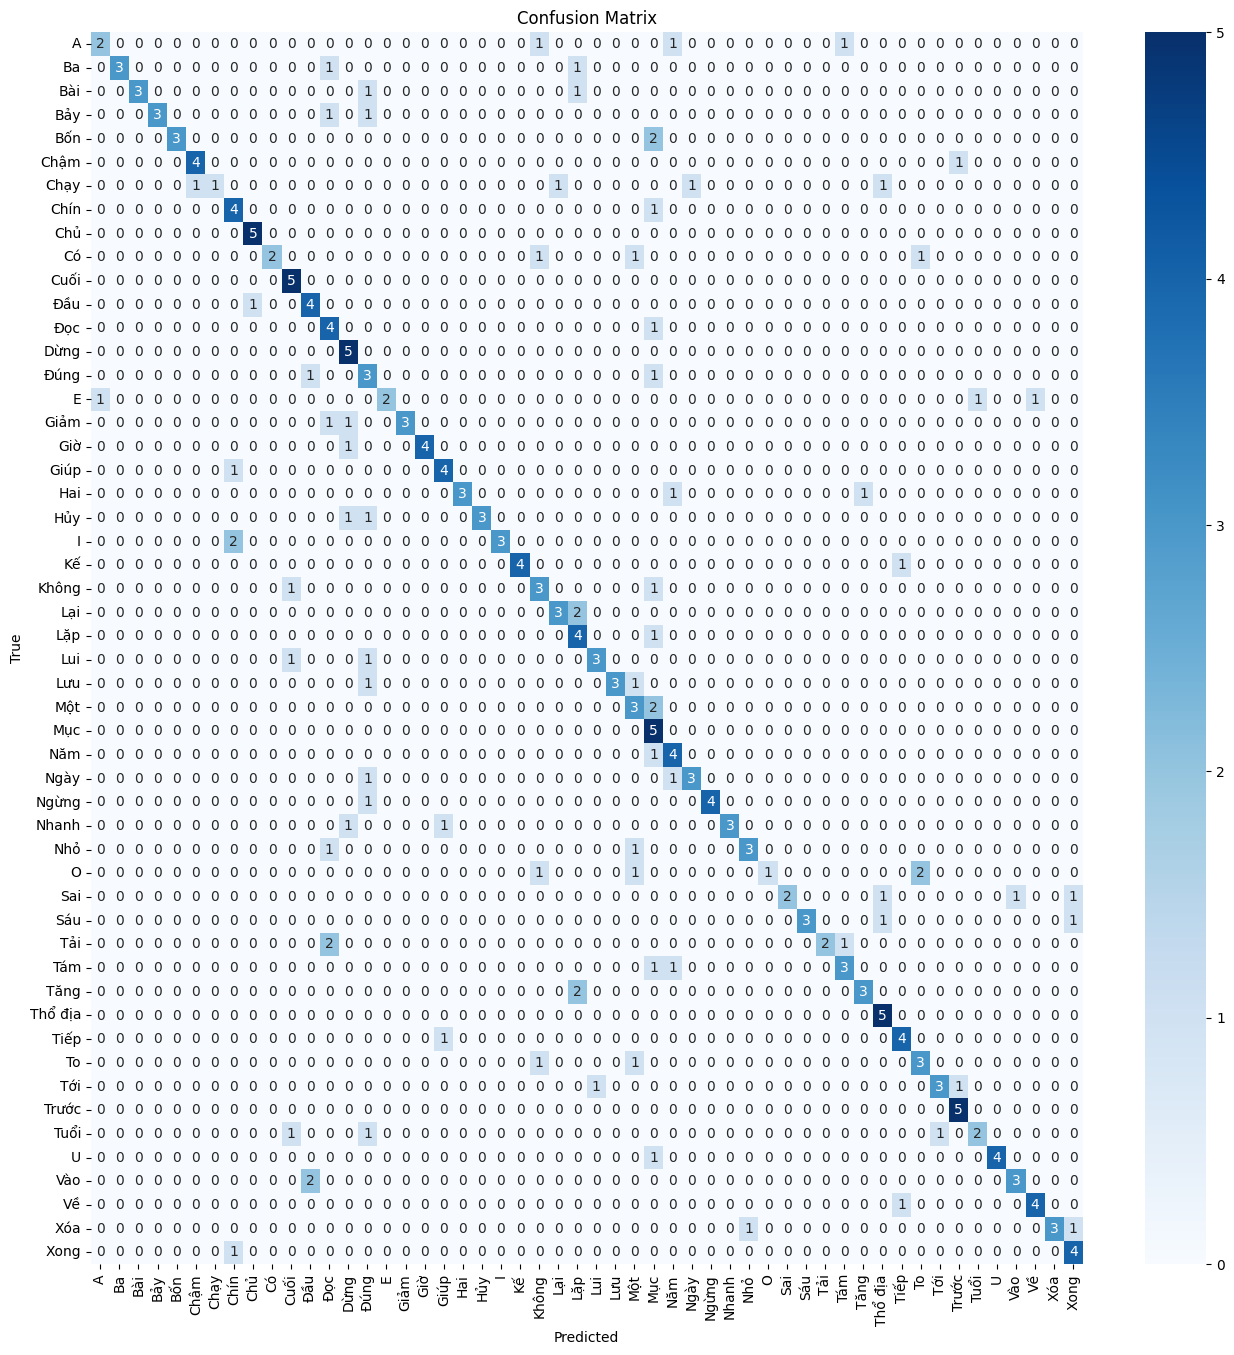

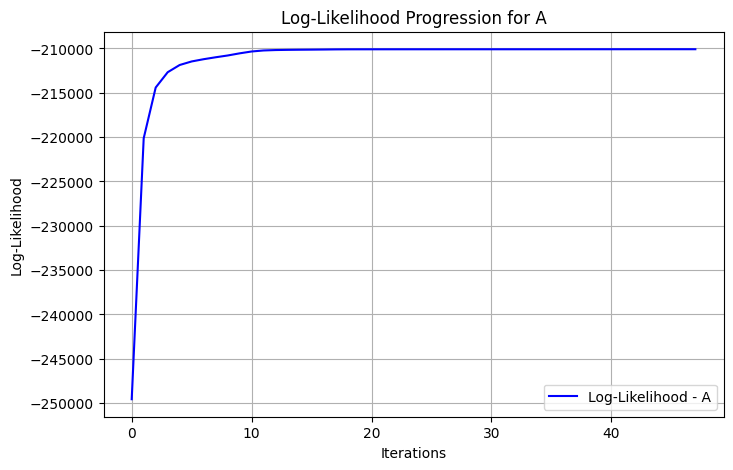

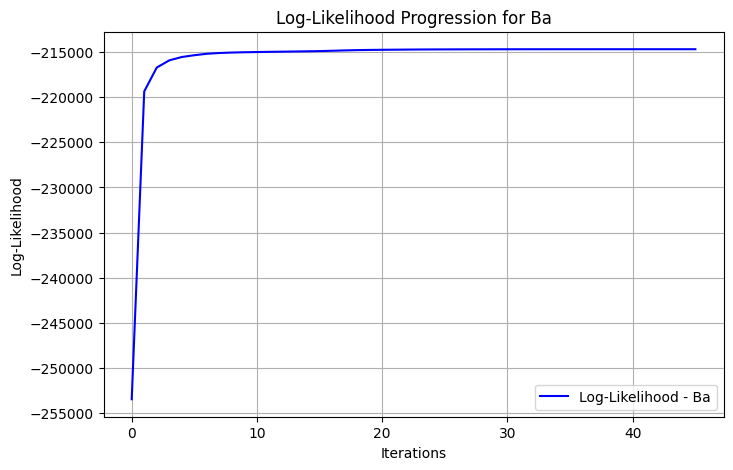

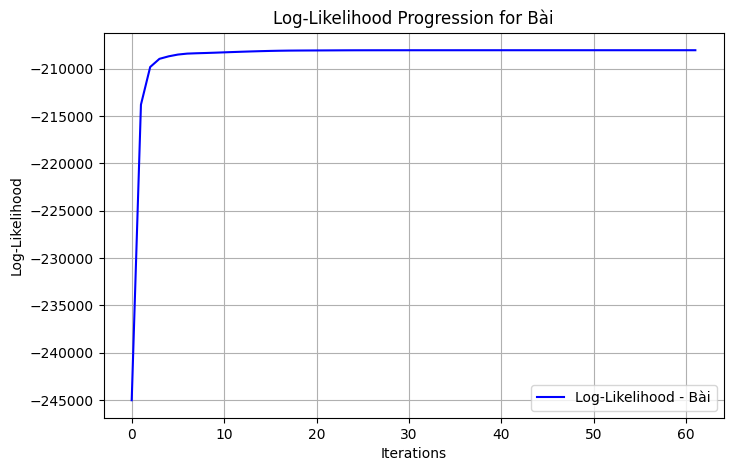

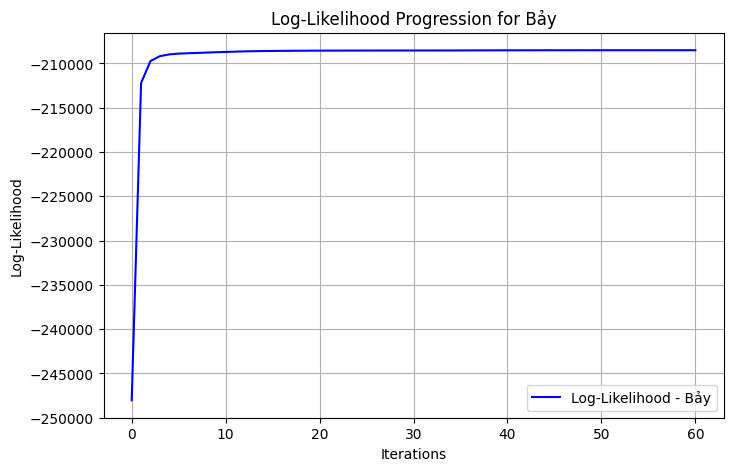

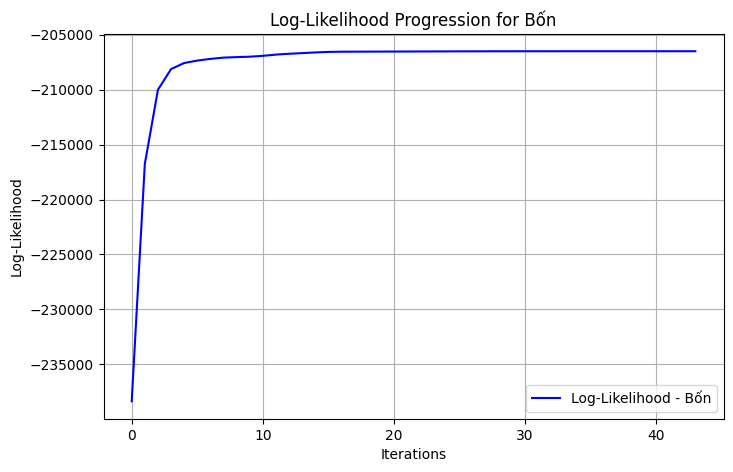

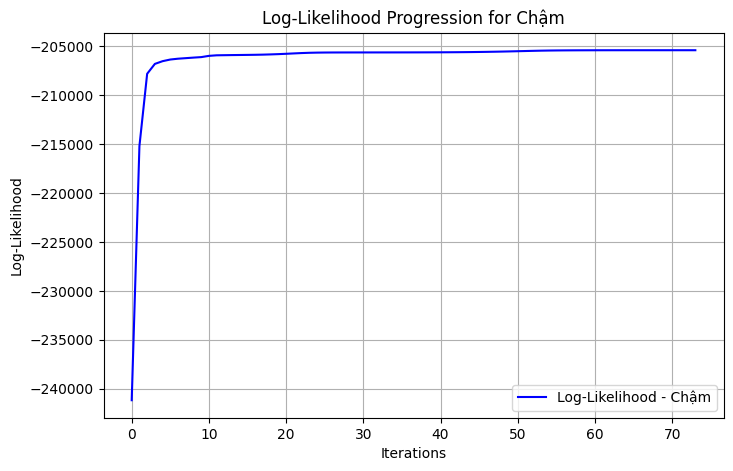

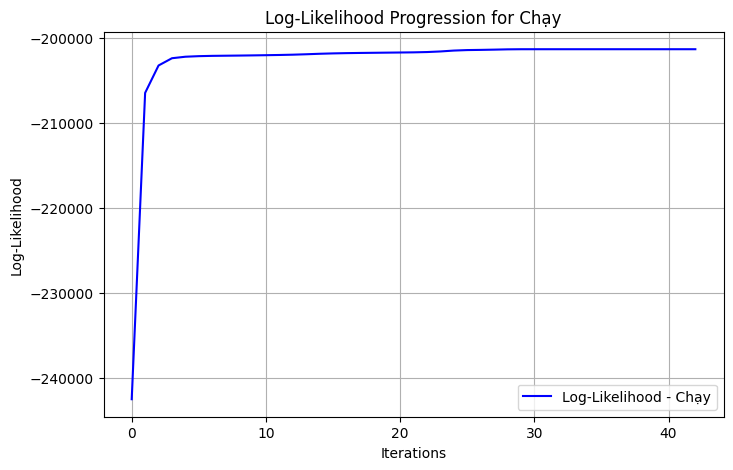

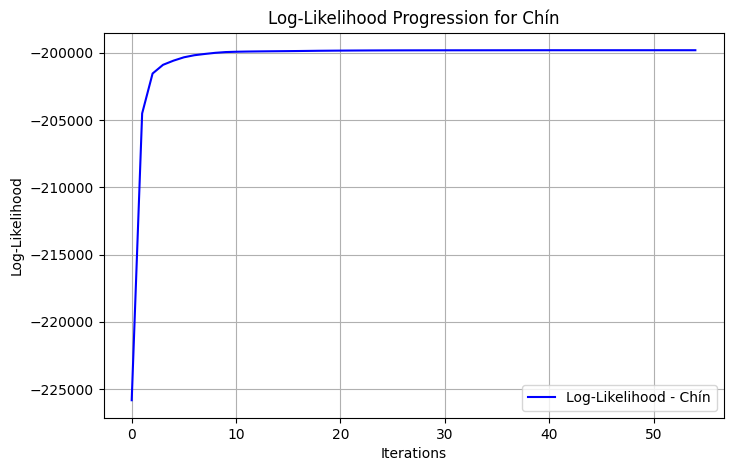

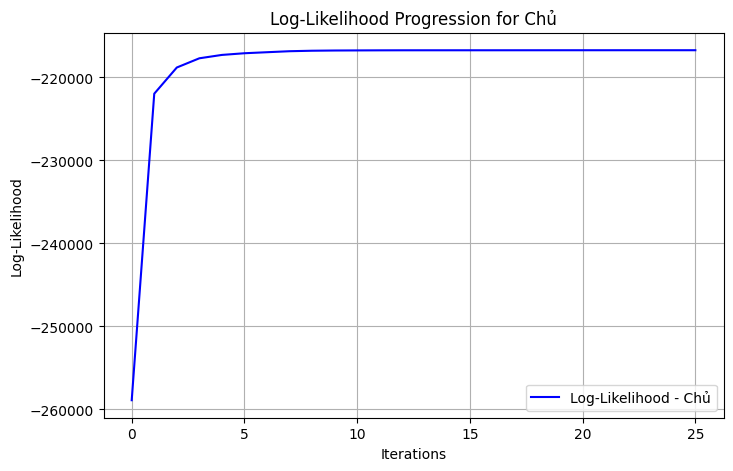

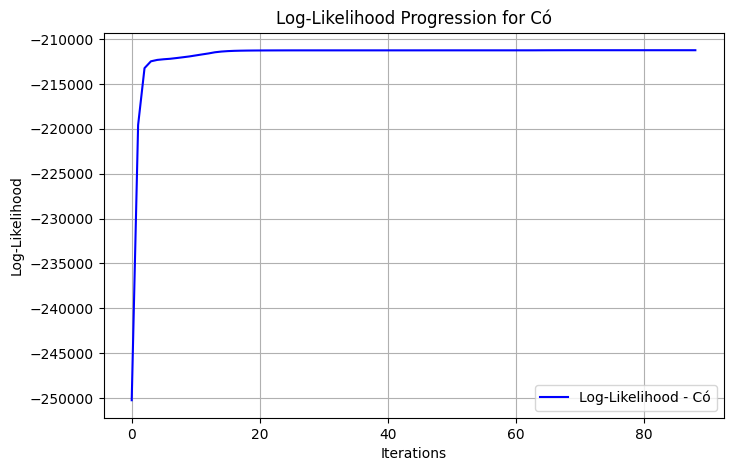

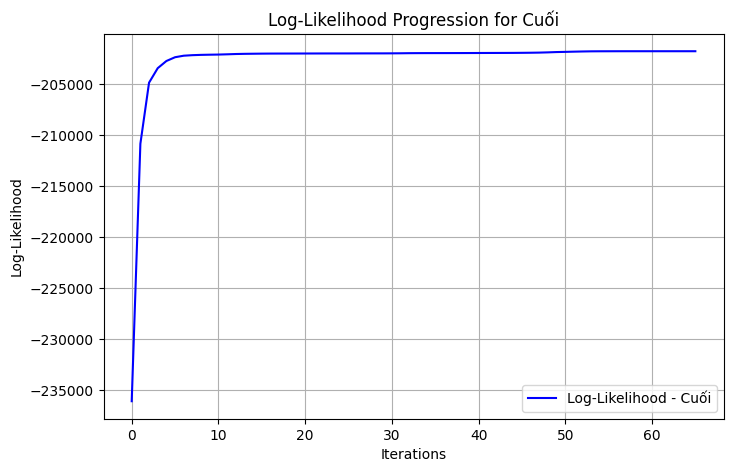

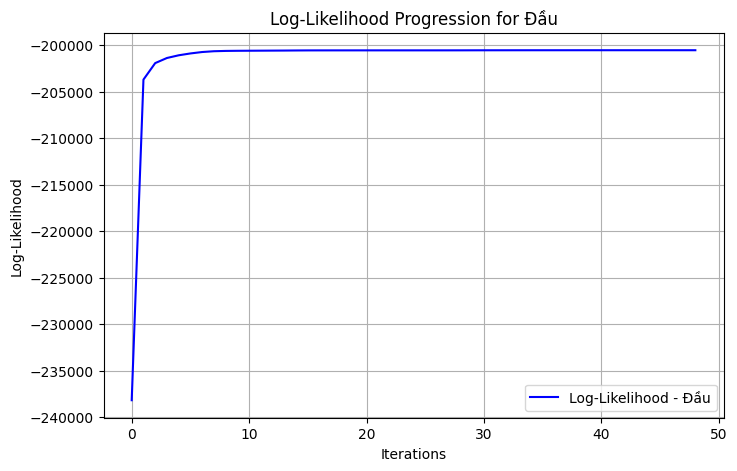

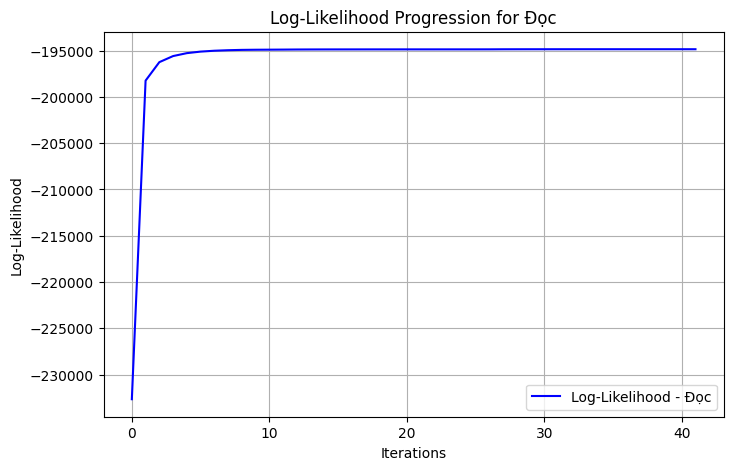

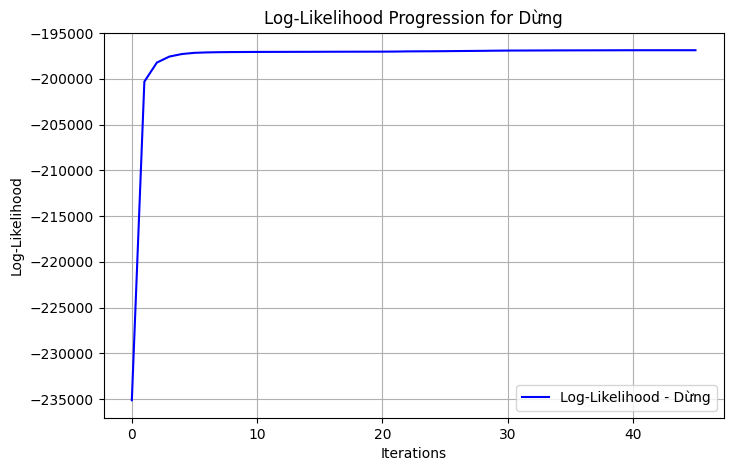

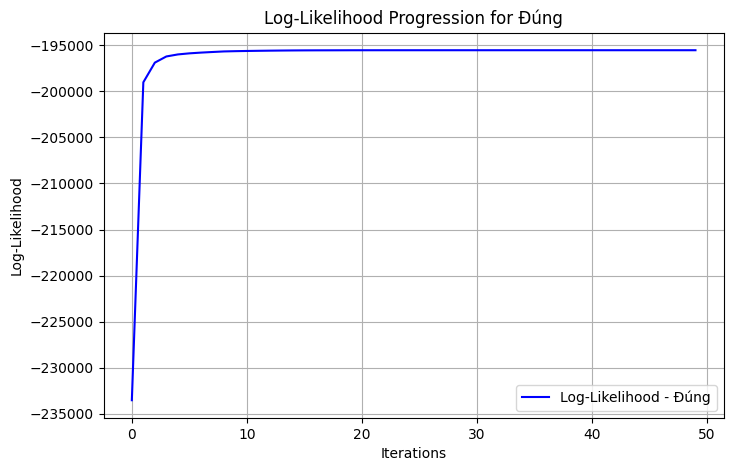

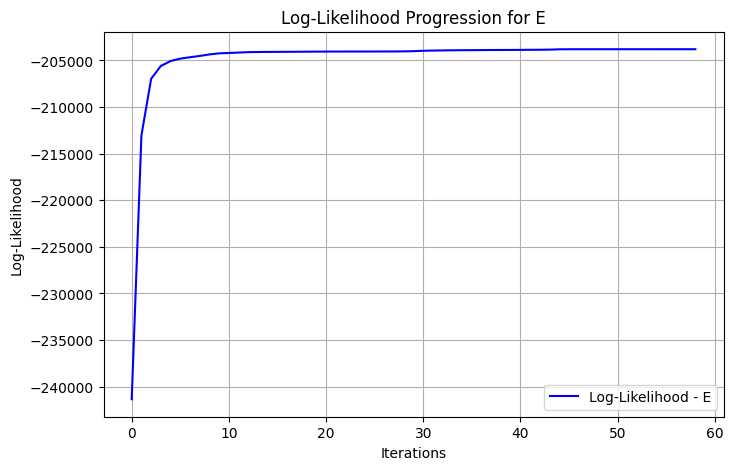

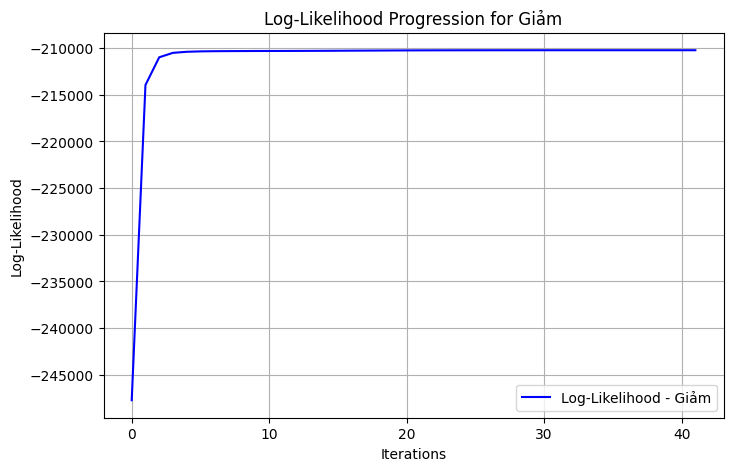

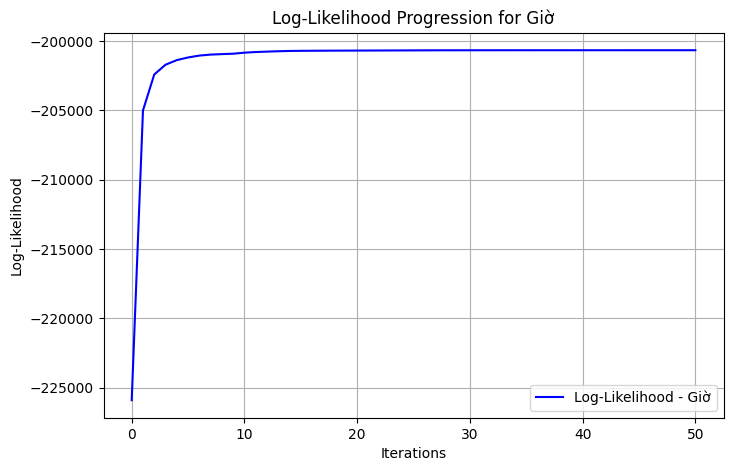

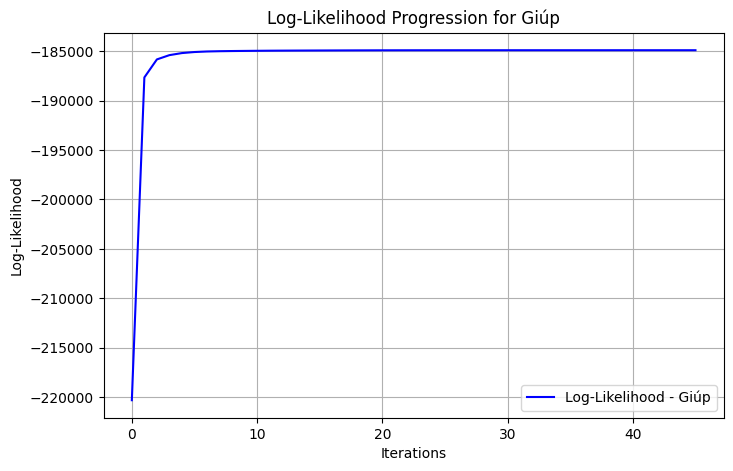

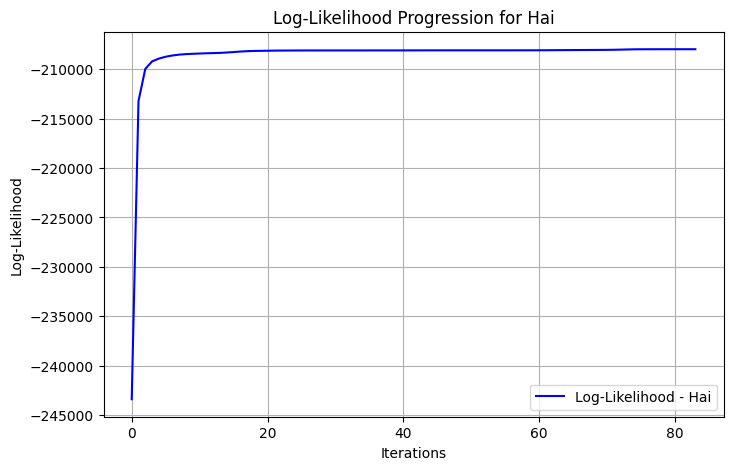

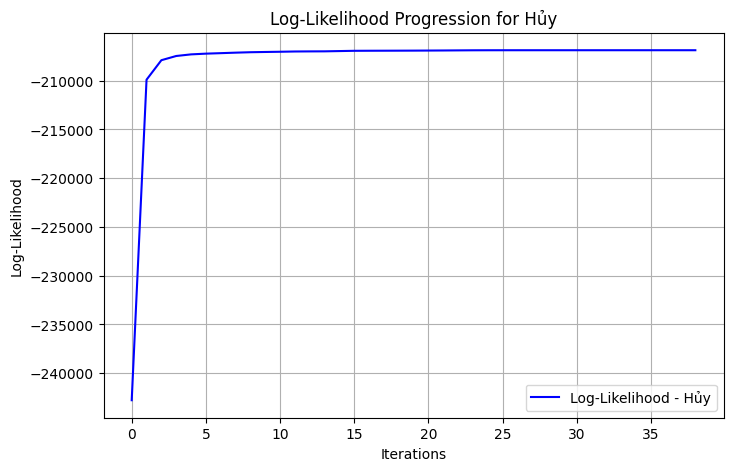

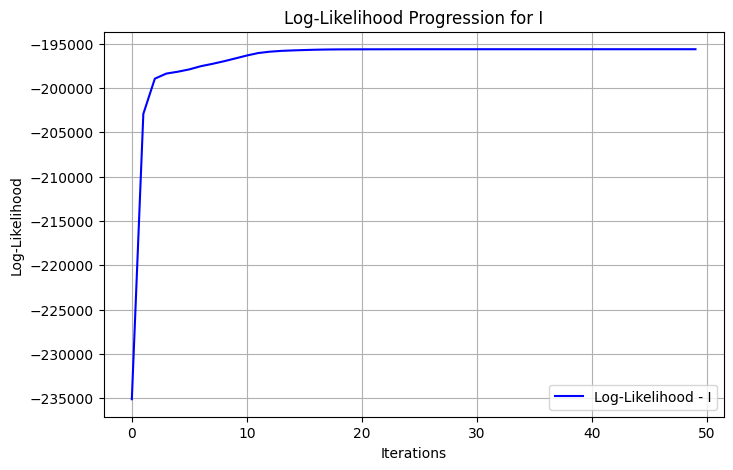

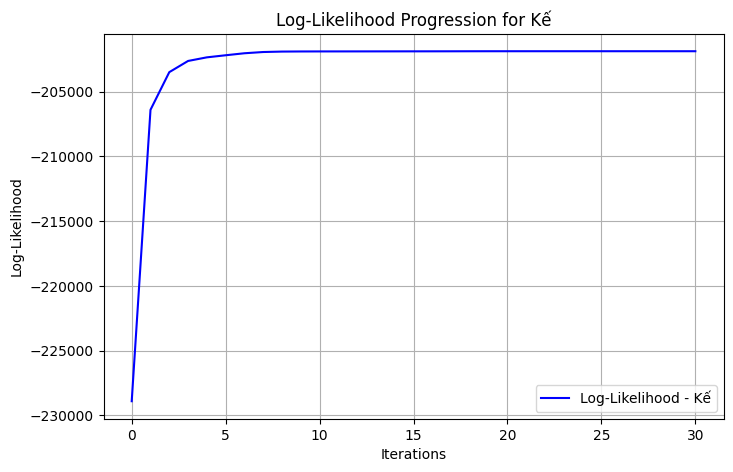

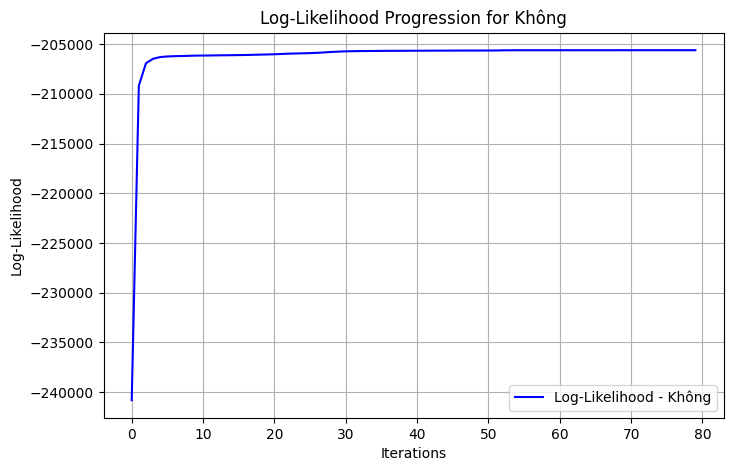

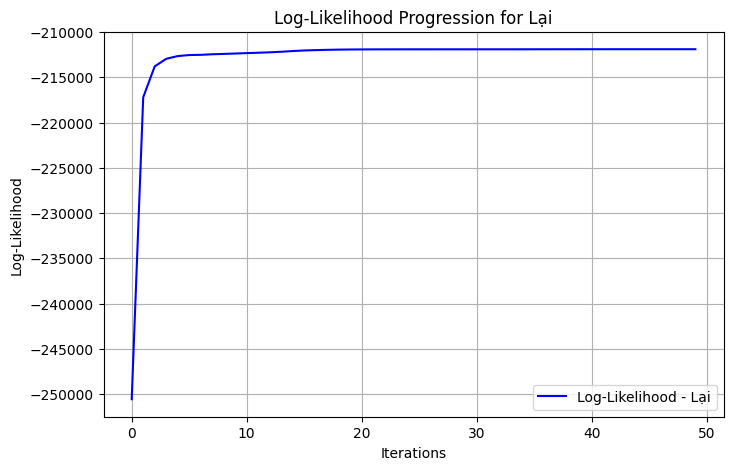

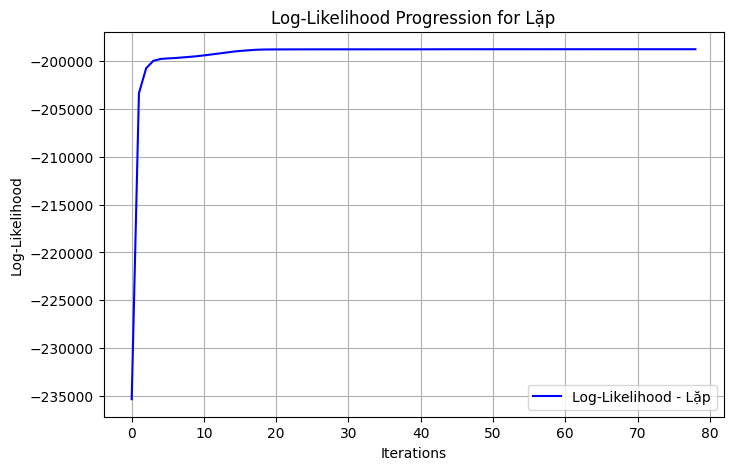

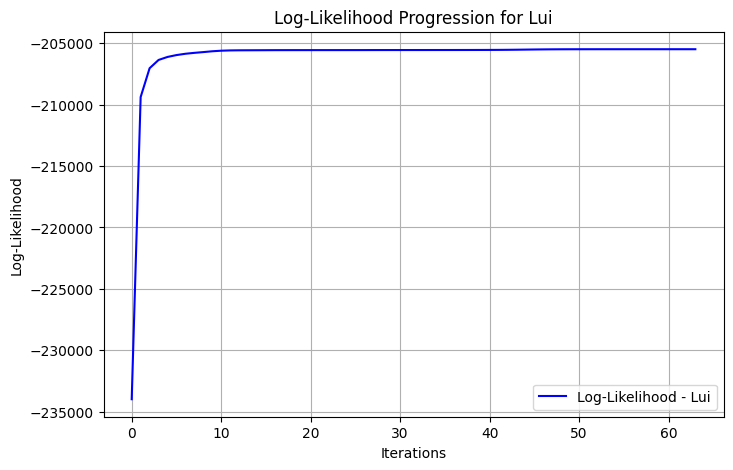

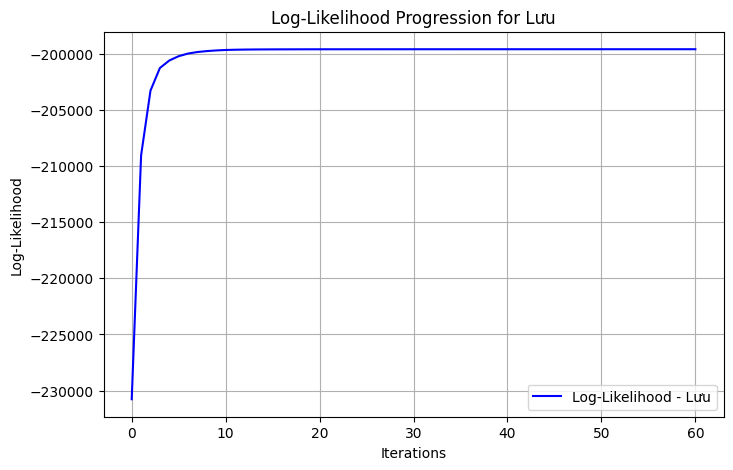

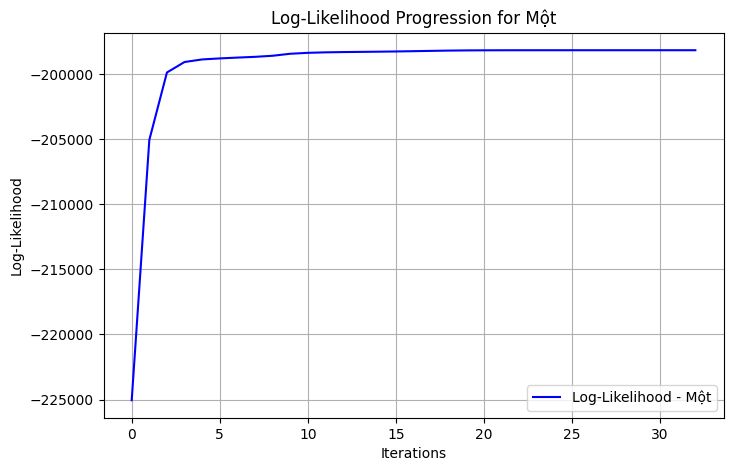

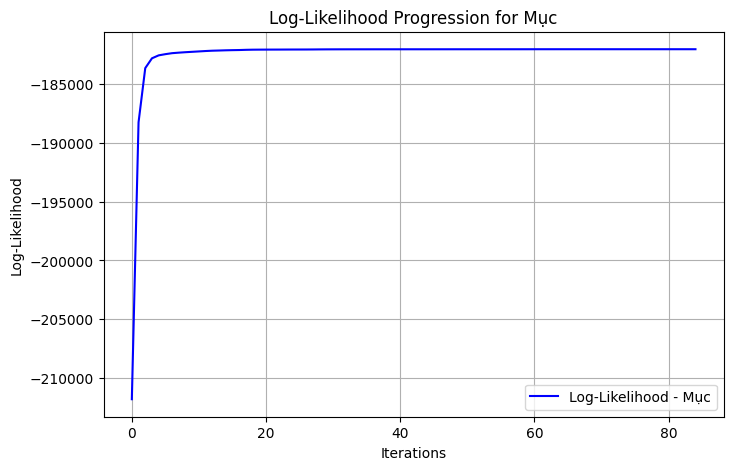

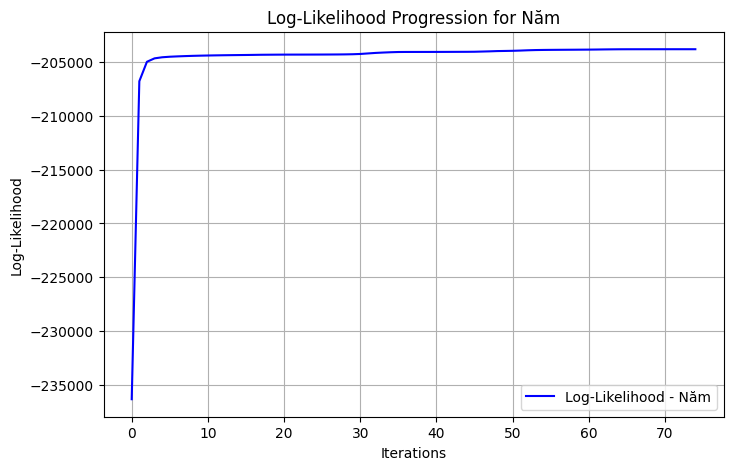

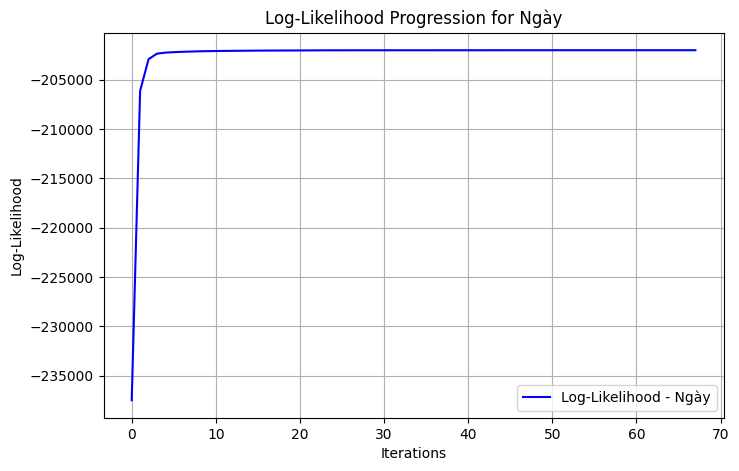

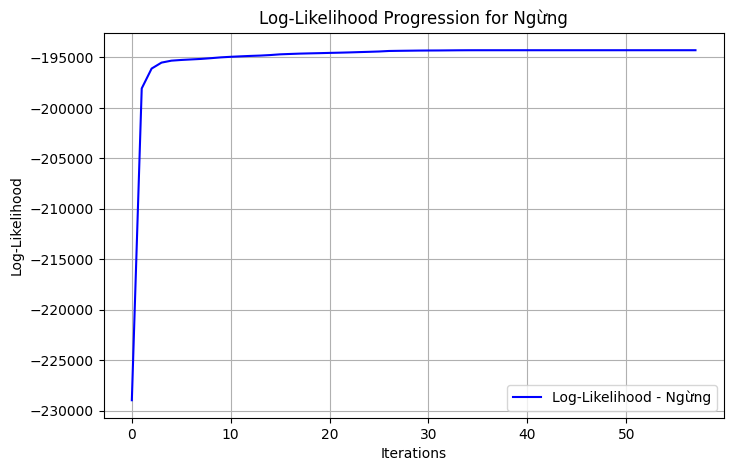

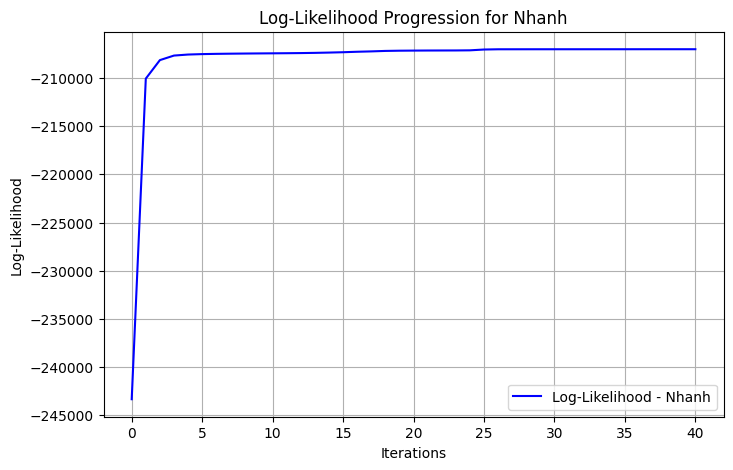

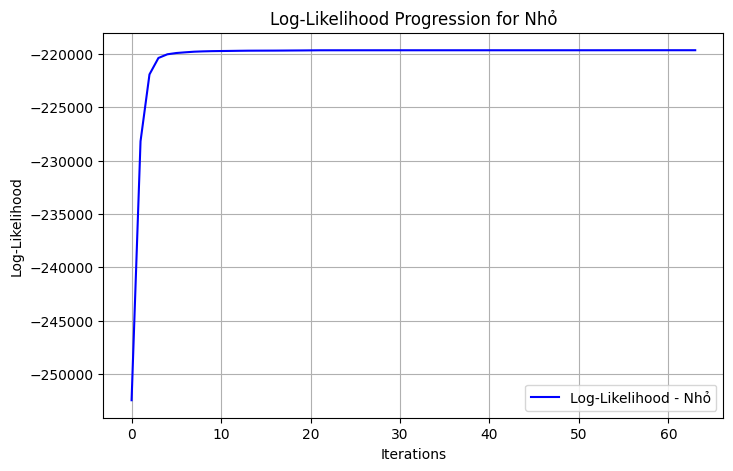

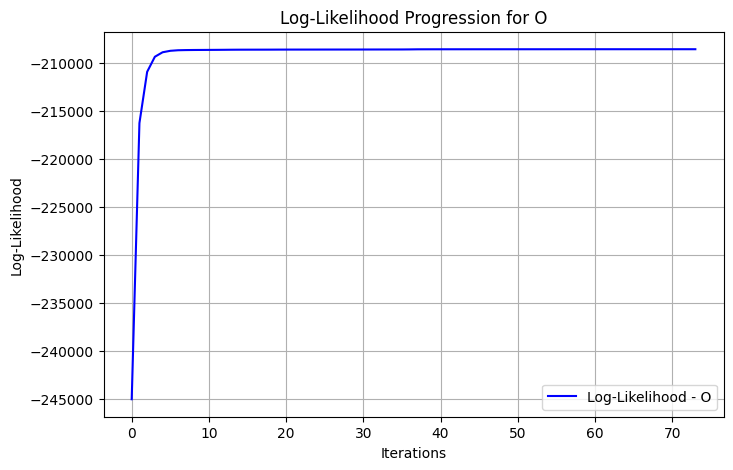

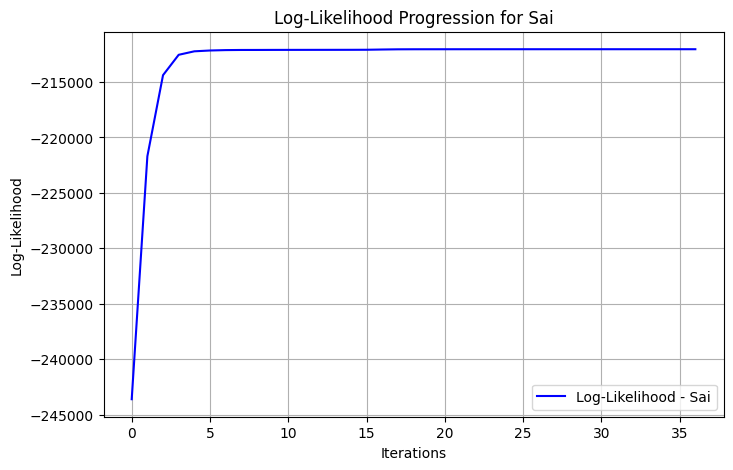

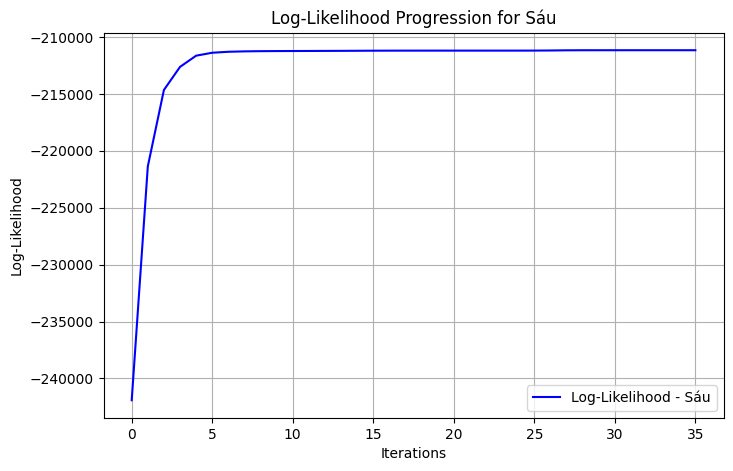

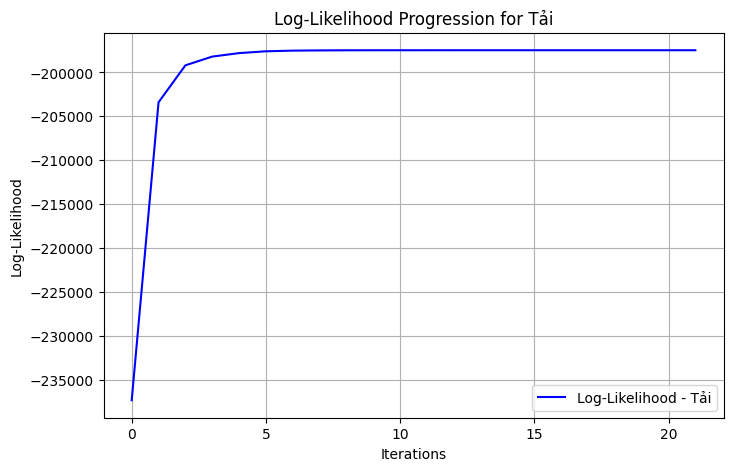

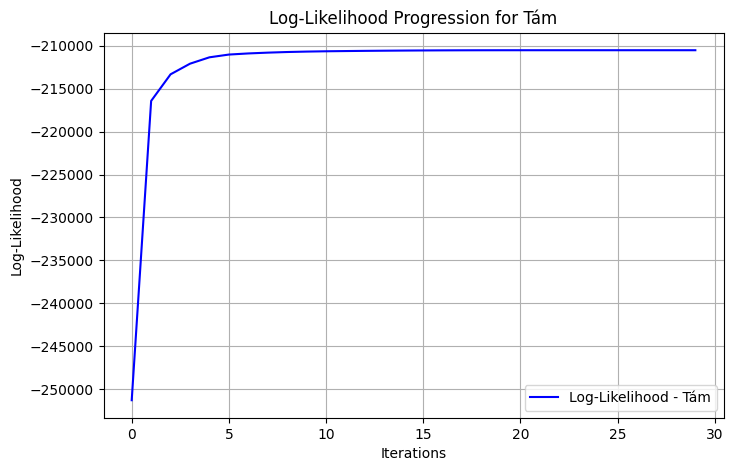

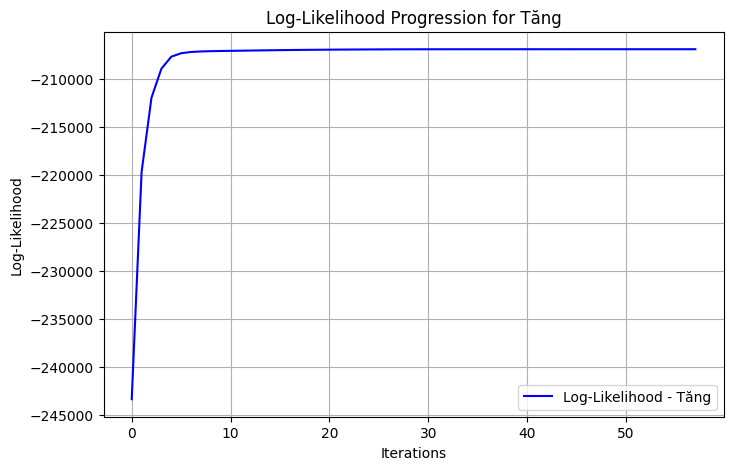

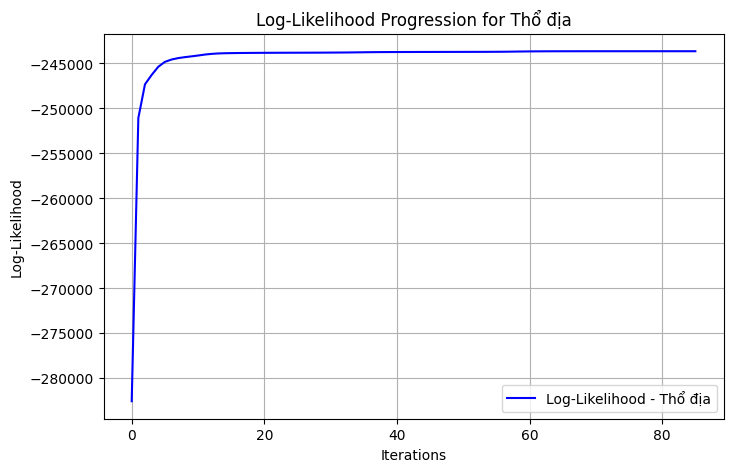

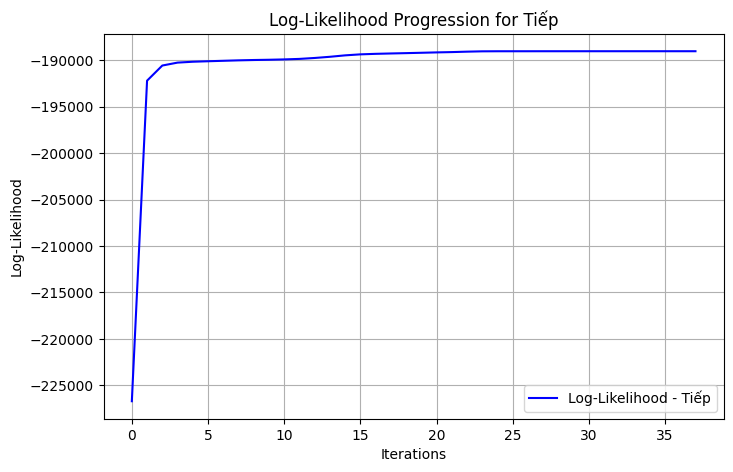

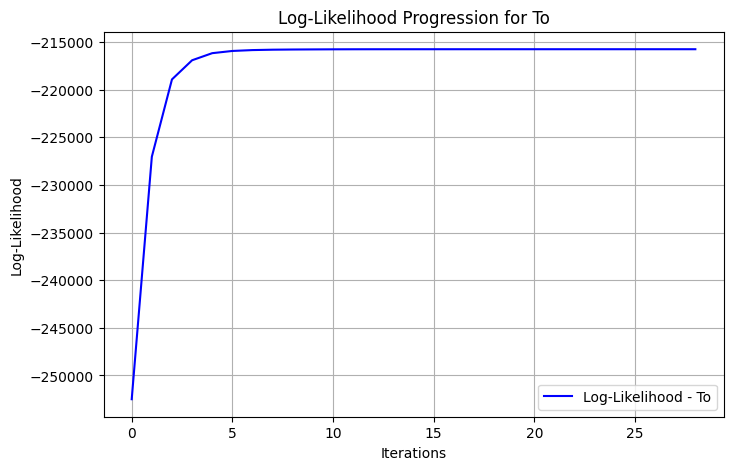

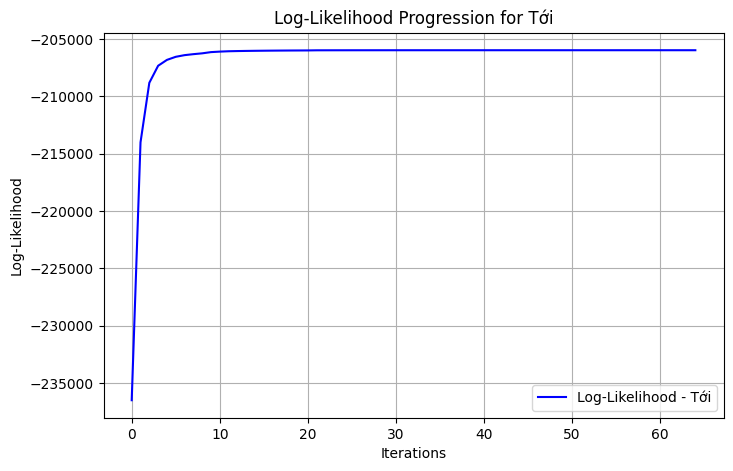

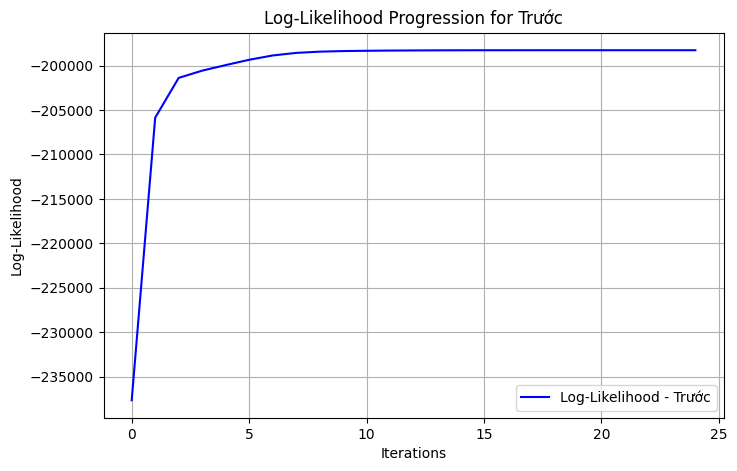

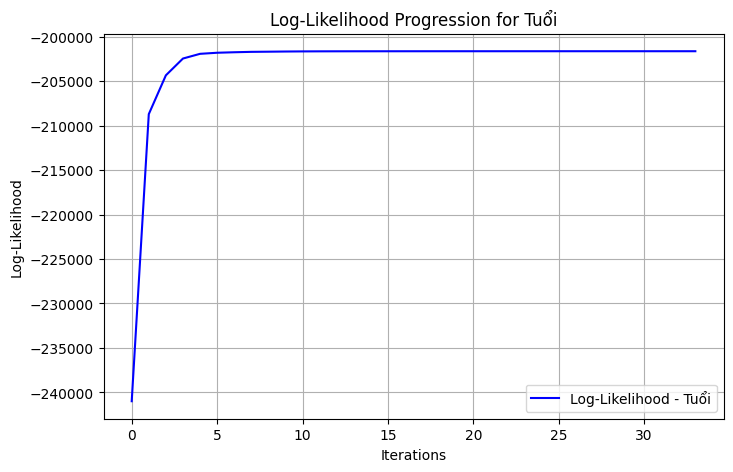

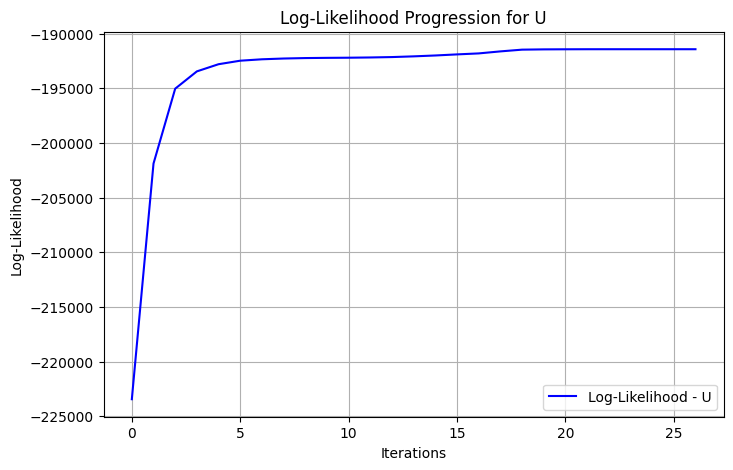

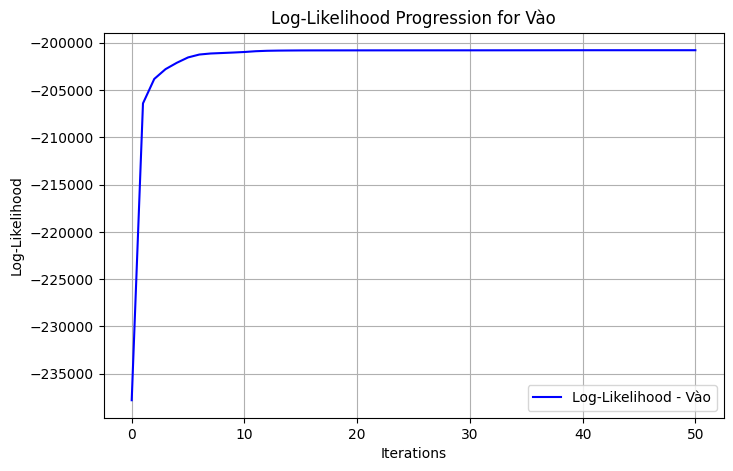

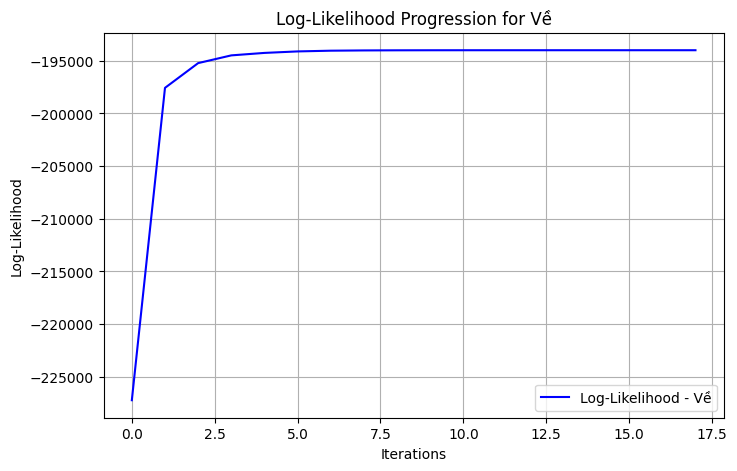

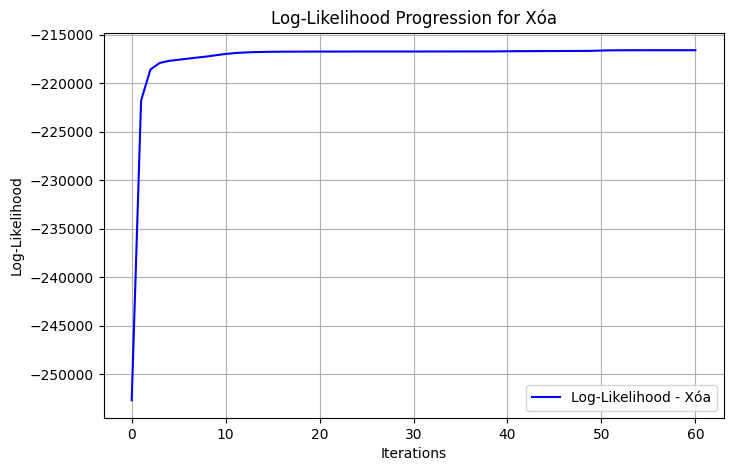

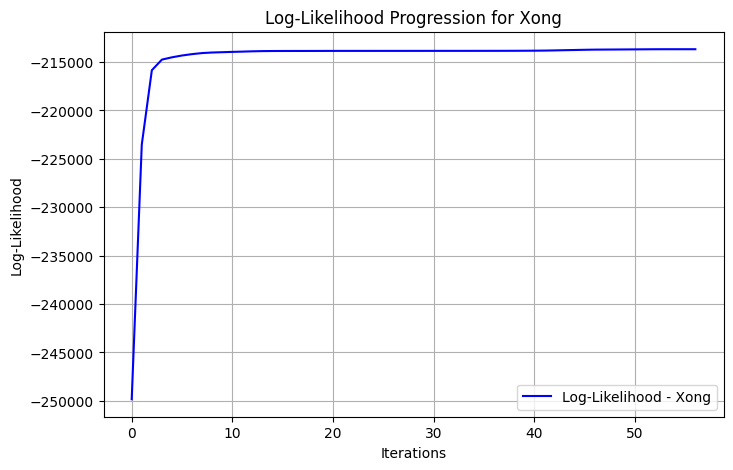

In [17]:
if __name__ == '__main__':
    hmm_train = HMMTraining()
    hmm_train.train()
    hmm_train.save_model()
    hmm_train.evaluation()
    hmm_train.plot_log_likelihood()